In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from train_gtex import *
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from src.train_utils import forward
from src.distributions import *
from src.eval_utils import *
from src.baselines import *
from tqdm import tqdm
from matplotlib_venn import venn3, venn3_circles
import blitzgsea as blitz
from gseapy.plot import barplot, dotplot
from gseapy.plot import gseaplot
import gseapy as gp
from Bio.KEGG import REST
from src.plot_utils import enr_barplot
from sklearn.decomposition import PCA
import matplotlib
from matplotlib.ticker import MultipleLocator
import torch
import os
sns.set_style("whitegrid")

/home/rv340/anaconda3/envs/multitissue/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
MODEL_PATH = '/local/scratch-2/rv340/multitissue/models/normalised_model_default.pth'
RESULTS_DIR = '/home/rv340/HYFA/results'
GTEX_FILE = '/local/scratch/rv340/gtex/GTEX_data.csv'
METADATA_FILE = '/local/scratch/rv340/gtex/GTEx_Analysis_2017-06-05_v8_Annotations_SubjectPhenotypesDS.txt'

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument('--config', dest='config', default='configs/default.yaml', type=str)
args, unknown = parser.parse_known_args()

# Initialise wandb
wandb.init(project='multitissue_imputation', config=args.config, mode='disabled')
config = wandb.config
print(config)

{'gpu': 0, 'sweep': False, 'lr': 0.00045568167228053424, 'batch_size': 63, 'epochs': 200, 'patience': 30, 'dropout': 0.17385777664292695, 'bn': True, 'use_demographic_information': True, 'update_edge_attr': False, 'n_graph_layers': 2, 'n_hidden_layers': 1, 'n_hidden_layers_pred': 2, 'n_hidden_layers_prior_var': 0, 'meta_G': 50, 'd_patient': 71, 'd_gene': 48, 'd_edge_attr': 98, 'd_tissue': 120, 'd_edge': 28, 'n_heads': 28, 'beta': 0, 'n_top_genes': None, 'attention_strategy': 'patient', 'metagenes_encoder': 'plain', 'loss_type': 'normal', 'layer': 'gat', 'activation': 'swish', 'norm': 'batch'}


In [ ]:
# Load data
adata = GTEx_v8_normalised_adata(file=GTEX_FILE)

# Dictionaries
_, tissue_dict = map_to_ids(adata.obs['Tissue'])
tissue_dict_inv = {v: k for k, v in tissue_dict.items()}

# Split train/val/test
donors = adata.obs['Participant ID'].values
train_donors, test_donors = split_patient_train_test(donors, train_rate=0.8)
train_donors, val_donors = split_patient_train_test(train_donors, train_rate=0.75)
train_mask = np.isin(donors, train_donors)
test_mask = np.isin(donors, test_donors)
val_mask = np.isin(donors, val_donors)
# print(train_patients, val_patients, test_patients)

collate_fn = Data.from_datalist
dtype = torch.float32 # torch.double
train_dataset = HypergraphDataset(adata[train_mask], dtype=dtype, disjoint=True, static=False)
val_dataset = HypergraphDataset(adata[val_mask], dtype=dtype, disjoint=True, static=True)
test_dataset = HypergraphDataset(adata[test_mask], dtype=dtype, static=True)
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, collate_fn=collate_fn, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, collate_fn=collate_fn, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, collate_fn=collate_fn, shuffle=False)

Trying to set attribute `.obs` of view, copying.


In [ ]:
# device = torch.device("cpu")
# Use certain GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "{}".format(config.gpu)
device = torch.device("cuda:{}".format(config.gpu) if torch.cuda.is_available() else "cpu")

# Select dynamic/static node types
config.update({'static_node_types': {'Tissue': (len(adata.obs['Tissue_idx'].unique()), config.d_tissue),
                            'metagenes': (config.meta_G, config.d_gene)}}, allow_val_change=True)
config.update({'dynamic_node_types': {'Participant ID': (len(adata.obs['Participant ID'].unique()), config.d_patient)}}, allow_val_change=True)

# Model
config.G = adata.shape[-1]
model = HypergraphNeuralNet(config).to(device)  # .double()

In [ ]:
model.load_state_dict(torch.load(MODEL_PATH))
model.eval();

#### Plot tissue embeddings

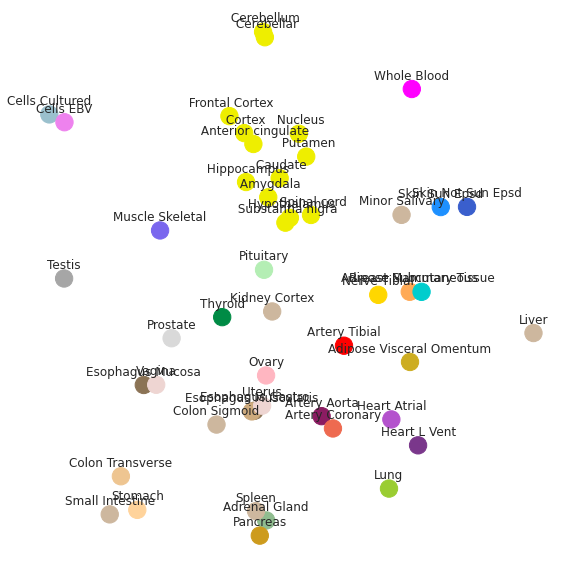

In [ ]:
params = model.params['Tissue'].cpu().detach().numpy()

tissue_params_2d = TSNE(n_components=2,
                        learning_rate='auto',
                        init='random',
                        random_state=0).fit_transform(params)

plt.figure(figsize=(8, 8))
colors = ['#ffaa56', '#cdad22', '#8fbc8f', '#8b1c62', '#ee6a50', '#ff0000', '#eeee00', '#eeee00', '#eeee00',
          '#eeee00', '#eeee00', '#eeee00', '#eeee00', '#eeee00', '#eeee00', '#eeee00', '#eeee00', '#eeee00',
          '#eeee00', '#00cdcd', '#9ac0cd', '#ee82ee', '#cdb79e', '#eec591', '#8b7355', '#8b7355', '#cdaa7d',
          '#b452cd', '#7a378b', '#cdb79e', '#cdb79e', '#9acd32', '#cdb79e', '#7A67EE', '#FFD700', '#FFB6C1',
          '#CD9B1D', '#B4EEB4', '#D9D9D9', '#3A5FCD', '#1E90FF', '#CDB79E', '#CDB79E', '#FFD39B', '#A6A6A6',
          '#008B45', '#EED5D2', '#EED5D2', '#FF00FF']
ax = plt.gca()
x1, x2 = tissue_params_2d.T
ax.scatter(x1, x2,
           c=colors,
           s=300)

for t, i in tissue_dict.items():
    x_coord = x1[i]
    y_coord = x2[i]
    txt = t.replace('_', ' ').replace('Brain', '')
        
    ax.annotate(txt, (x_coord, y_coord),
                textcoords="offset points",  # how to position the text
                xytext=(0, 10),  # distance from text to points (x,y)
                fontsize=12,
                # fontweight='bold',
                # rotation=45,
                ha='center')
plt.axis('off')
# plt.title('Tissue embeddings from multi-tissue imputation model', fontsize=14)
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/figures/tsne_tissue_embeddings.pdf', bbox_inches='tight');

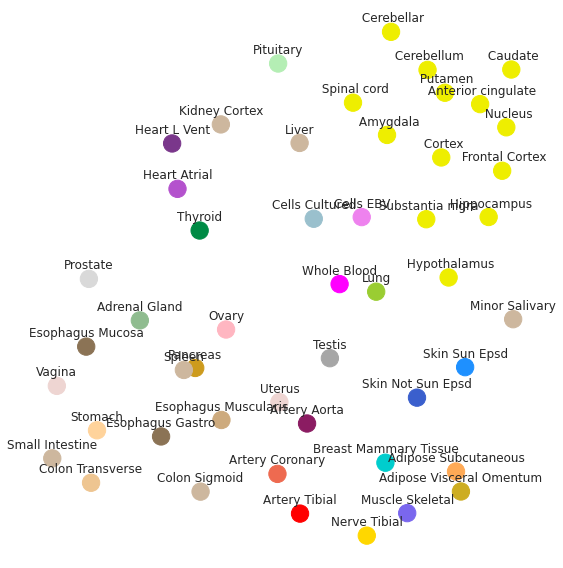

In [ ]:
params = model.params['Tissue'].cpu().detach().numpy()

tissue_params_2d = umap.UMAP().fit_transform(params)

plt.figure(figsize=(8, 8))
colors = ['#ffaa56', '#cdad22', '#8fbc8f', '#8b1c62', '#ee6a50', '#ff0000', '#eeee00', '#eeee00', '#eeee00',
          '#eeee00', '#eeee00', '#eeee00', '#eeee00', '#eeee00', '#eeee00', '#eeee00', '#eeee00', '#eeee00',
          '#eeee00', '#00cdcd', '#9ac0cd', '#ee82ee', '#cdb79e', '#eec591', '#8b7355', '#8b7355', '#cdaa7d',
          '#b452cd', '#7a378b', '#cdb79e', '#cdb79e', '#9acd32', '#cdb79e', '#7A67EE', '#FFD700', '#FFB6C1',
          '#CD9B1D', '#B4EEB4', '#D9D9D9', '#3A5FCD', '#1E90FF', '#CDB79E', '#CDB79E', '#FFD39B', '#A6A6A6',
          '#008B45', '#EED5D2', '#EED5D2', '#FF00FF']
ax = plt.gca()
x1, x2 = tissue_params_2d.T
ax.scatter(x1, x2,
           c=colors,
           s=300)

for t, i in tissue_dict.items():
    x_coord = x1[i]
    y_coord = x2[i]
    txt = t.replace('_', ' ').replace('Brain', '')
        
    ax.annotate(txt, (x_coord, y_coord),
                textcoords="offset points",  # how to position the text
                xytext=(0, 10),  # distance from text to points (x,y)
                fontsize=12,
                # fontweight='bold',
                # rotation=45,
                ha='center')

    
plt.axis('off')
# plt.title('Tissue embeddings from multi-tissue imputation model', fontsize=14)
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/figures/umap_tissue_embeddings.pdf', bbox_inches='tight');

#### Example: predictions validation set

In [ ]:
d = next(iter(val_loader))

In [ ]:
with torch.no_grad():
    out, node_features = forward(d, model, device, preprocess_fn=None, use_latent_mean=True)
    x_pred = torch.distributions.normal.Normal(loc=out['px_rate'], scale=out['px_r']).mean

In [ ]:
x_pred

tensor([[-0.0942,  0.1930, -0.0117,  ..., -0.1641, -0.3732, -0.6240],
        [ 0.5508, -0.1576,  0.3175,  ..., -0.1094, -0.4804, -0.4947],
        [ 0.4153,  0.2576, -0.4670,  ..., -0.1982, -0.7243, -0.7867],
        ...,
        [ 0.0668, -0.1317,  0.6310,  ...,  0.4927, -0.3985,  0.1665],
        [ 0.4716, -1.1849,  1.2882,  ...,  0.1269, -1.7253,  0.4976],
        [-0.1450, -0.4807,  0.5536,  ...,  0.3810,  0.1107,  0.3074]],
       device='cuda:0')

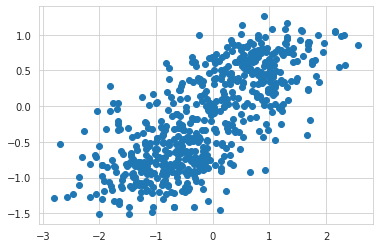

In [ ]:
idx = 9228
plt.scatter(d.x_target[:, idx].cpu().numpy(), x_pred[:, idx].cpu().numpy())

/home/rv340/anaconda3/envs/multitissue/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

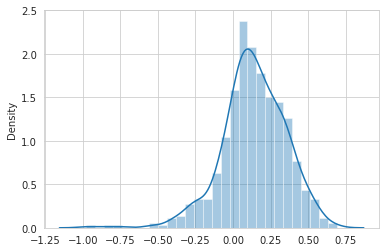

In [ ]:
corrs = r2_score(d.x_target.cpu().numpy(), x_pred.cpu().numpy(), sample_corr=True)  # pearson_correlation_score
sns.distplot(corrs);

####  Examine distributions of latent variables

In [ ]:
d = next(iter(val_loader))

mus = []
for d in val_loader:
    with torch.no_grad():
        out, node_features = forward(d, model, device, preprocess_fn=None)
        
        dynamic_node_features, static_node_features = node_features
        mus.append(dynamic_node_features['Participant ID']['mu'])
        # var.append(dynamic_node_features['Participant ID']['var'])
mus = torch.cat(mus, dim=0).cpu().numpy()
# var = torch.cat(var, dim=0).cpu().numpy()

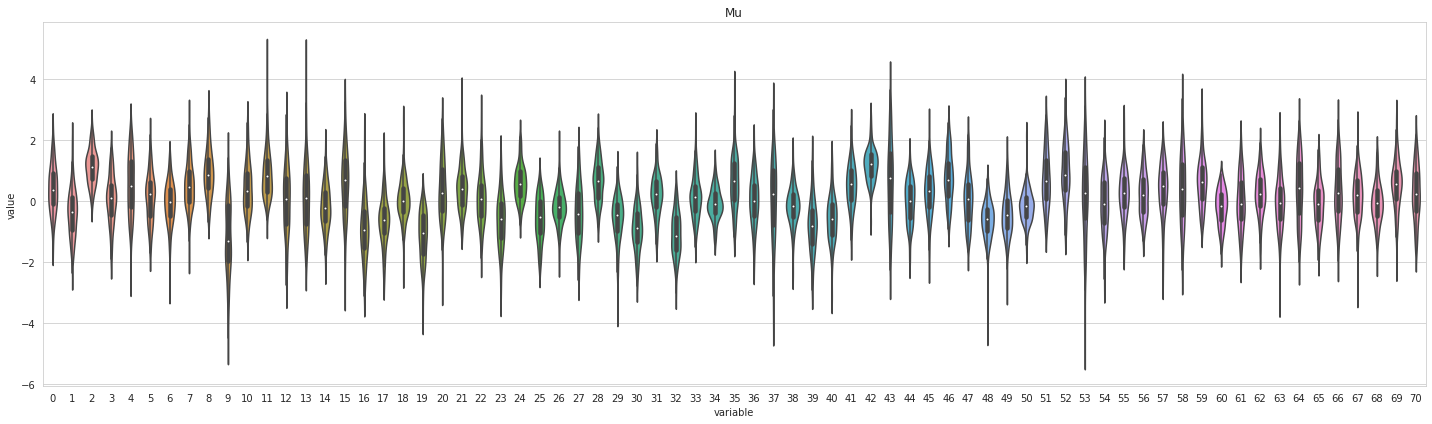

In [ ]:
plt.figure(figsize=(20, 6))
mus_df = pd.DataFrame(mus)
sns.violinplot(data=mus_df.melt(), y='value', x='variable')
plt.title('Mu')
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/figures/latent_variable_distributions.pdf', bbox_inches='tight');

#### Compare to baselines

In [ ]:
def rho(x, x_pred):
    return np.mean(pearson_correlation_score(x, x_pred, sample_corr=True))
metric_fns = [rho]
    
model.eval()
score_fn = pearson_correlation_score

validate = False
source_tissues = ['Whole_Blood']    # , 'Skin_Sun_Epsd', 'Skin_Not_Sun_Epsd', 'Adipose_Subcutaneous'
target_tissues = [t for t in adata.obs['Tissue'].unique() if t not in source_tissues]

results_df = pd.DataFrame([], columns=['score', 'source', 'target', 'method'])
for tt in tqdm(target_tissues):
    # Name source and target tissues
    source_name = ', '.join(source_tissues)
    target_name = tt.replace('_', ' ')
    # print(tt)
    
    # Create datasets
    aux_train_dataset = HypergraphDataset(adata[train_mask],
                                      obs_source={'Tissue': source_tissues},
                                      obs_target={'Tissue': [tt]})
    source_donor_ids = aux_train_dataset.adata_source.obs['Participant ID']
    target_donor_ids = aux_train_dataset.adata_target.obs['Participant ID']
    assert (source_donor_ids.values == target_donor_ids.values).all()
    
    aux_val_dataset = HypergraphDataset(adata[val_mask],
                                      obs_source={'Tissue': source_tissues},
                                      obs_target={'Tissue': [tt]})
    source_donor_ids = aux_val_dataset.adata_source.obs['Participant ID']
    target_donor_ids = aux_val_dataset.adata_target.obs['Participant ID']
    assert (source_donor_ids.values == target_donor_ids.values).all()
    
    aux_test_dataset = HypergraphDataset(adata[test_mask],
                                      obs_source={'Tissue': source_tissues},
                                      obs_target={'Tissue': [tt]})
    source_donor_ids = aux_test_dataset.adata_source.obs['Participant ID']
    target_donor_ids = aux_test_dataset.adata_target.obs['Participant ID']
    assert (source_donor_ids.values == target_donor_ids.values).all()

    # Prepare source expression data
    x_train_ = aux_train_dataset.adata_source.layers['x'].toarray()
    x_train_covs = aux_train_dataset.adata_source.obsm['Participant ID_feat'].toarray()
    x_val_ = aux_val_dataset.adata_source.layers['x'].toarray()
    x_val_covs = aux_val_dataset.adata_source.obsm['Participant ID_feat'].toarray()
    x_test_ = aux_test_dataset.adata_source.layers['x'].toarray()
    x_test_covs = aux_test_dataset.adata_source.obsm['Participant ID_feat'].toarray()
    
    y_train = aux_train_dataset.adata_target.layers['x'].toarray()
    y_val = aux_val_dataset.adata_target.layers['x'].toarray()
    y_test = aux_test_dataset.adata_target.layers['x'].toarray()
    
    # Append donor metadata
    x_train_aux = aux_train_dataset.adata_source.obsm['Participant ID_feat'].toarray()
    x_val_aux = aux_val_dataset.adata_source.obsm['Participant ID_feat'].toarray()
    x_test_aux = aux_test_dataset.adata_source.obsm['Participant ID_feat'].toarray()
    x_train = np.concatenate((x_train_, x_train_aux), axis=-1)
    x_val = np.concatenate((x_val_, x_val_aux), axis=-1)
    x_test = np.concatenate((x_test_, x_test_aux), axis=-1)
    
    if validate:
        x_test = x_val
        y_test = y_val
        x_test_ = x_val_
        x_test_covs = x_val_covs
    
    # Blood surrogate baseline
    sample_scores = score_fn(y_test, x_test_, sample_corr=True)
    
    # Append results
    scores = sample_scores
    df_ = pd.DataFrame({'score': scores,
                        'source': [source_name] * len(scores),
                        'target': [target_name] * len(scores),
                        'method': ['blood surrogate'] * len(scores)})
    results_df = pd.concat([results_df, df_])
    
    # Mean baseline
    means = y_train.mean(axis=0)
    y_test_pred = np.repeat(means[None, :], y_test.shape[0], axis=0)
    sample_scores = score_fn(y_test, y_test_pred, sample_corr=True)
    
    # Append results
    scores = sample_scores
    df_ = pd.DataFrame({'score': scores,
                        'source': [source_name] * len(scores),
                        'target': [target_name] * len(scores),
                        'method': ['mean'] * len(scores)})
    results_df = pd.concat([results_df, df_])
    
    # KNN baseline
    x_train_knn = np.concatenate((x_train_, y_train), axis=-1)
    test_nans = np.full((x_test_.shape[0], y_train.shape[1]), np.nan)
    x_test_knn = np.concatenate((x_test_, test_nans), axis=-1)
    x_knn = np.concatenate((x_train_knn, x_test_knn), axis=0)

    x_knn_covs = np.concatenate((x_train_covs, x_test_covs), axis=0)
    knn_imp = impute_knn(x_knn, covariates=x_knn_covs, k=20)
    knn_imp_ = knn_imp[x_train_.shape[0]:, x_train_.shape[1]:]
    sample_scores = score_fn(y_test, knn_imp_, sample_corr=True)
    
    # Append results
    scores = sample_scores
    df_ = pd.DataFrame({'score': scores,
                        'source': [source_name] * len(scores),
                        'target': [target_name] * len(scores),
                        'method': ['kNN'] * len(scores)})
    results_df = pd.concat([results_df, df_])
    
    # TEEBoT baseline.
    y_test_pred = PCA_linear_regression_baseline_v1(x_train, y_train, x_test)
    
    sample_scores = score_fn(y_test, y_test_pred, sample_corr=True)
    
    # Append results
    scores = sample_scores
    df_ = pd.DataFrame({'score': scores,
                        'source': [source_name] * len(scores),
                        'target': [target_name] * len(scores),
                        'method': ['TEEBoT'] * len(scores)})
    results_df = pd.concat([results_df, df_])
    
    # Hypergraph baseline
    aux_train_loader = DataLoader(aux_train_dataset, batch_size=config.batch_size, collate_fn=collate_fn, shuffle=True, drop_last=True)
    aux_val_loader = DataLoader(aux_val_dataset, batch_size=len(aux_val_dataset), collate_fn=collate_fn, shuffle=False)
    aux_test_loader = DataLoader(aux_test_dataset, batch_size=len(aux_test_dataset), collate_fn=collate_fn, shuffle=False)

    # Compute predictions and score
    model.eval()
    with torch.no_grad():
        if validate:
            d = next(iter(aux_val_loader))
        else:
            d = next(iter(aux_test_loader))

        out, node_features = forward(d, model, device, preprocess_fn=None)
        y_test_pred = out['px_rate'].cpu().numpy()  # torch.distributions.normal.Normal(loc=out['px_rate'], scale=out['px_r']).mean.cpu().numpy()
        y_test_ = d.x_target.cpu().numpy()
    assert np.allclose(y_test_, y_test)

    sample_scores = score_fn(y_test, y_test_pred, sample_corr=True)

    # Append results
    scores = sample_scores
    df_ = pd.DataFrame({'score': scores,
                        'source': [source_name] * len(scores),
                        'target': [target_name] * len(scores),
                        'method': ['HYFA (blood)'] * len(scores)})
    results_df = pd.concat([results_df, df_])

    # Hypergraph baseline (all tissues)
    # Select same set of individuals
    aux_val_dataset = HypergraphDataset(adata[val_mask],
                                      obs_source={'Participant ID': list(aux_val_dataset.donor_map.values())},
                                      obs_target={'Tissue': [tt]})
    aux_test_dataset = HypergraphDataset(adata[test_mask],
                                      obs_source={'Participant ID': list(aux_test_dataset.donor_map.values())},
                                      obs_target={'Tissue': [tt]})
    aux_val_loader = DataLoader(aux_val_dataset, batch_size=len(aux_val_dataset), collate_fn=collate_fn, shuffle=False)
    aux_test_loader = DataLoader(aux_test_dataset, batch_size=len(aux_test_dataset), collate_fn=collate_fn, shuffle=False)

    # Compute predictions and score
    model.eval()
    with torch.no_grad():
        if validate:
            d = next(iter(aux_val_loader))
        else:
            d = next(iter(aux_test_loader))

        out, node_features = forward(d, model, device, preprocess_fn=None)
        y_test_pred = out['px_rate'].cpu().numpy()  # torch.distributions.normal.Normal(loc=out['px_rate'], scale=out['px_r']).mean.cpu().numpy()
        y_test_ = d.x_target.cpu().numpy()

    sample_scores = score_fn(y_test, y_test_pred, sample_corr=True)

    # Append results
    scores = sample_scores
    df_ = pd.DataFrame({'score': scores,
                        'source': [source_name] * len(scores),
                        'target': [target_name] * len(scores),
                        'method': ['HYFA (all)'] * len(scores)})
    results_df = pd.concat([results_df, df_])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [07:31<00:00,  9.40s/it]


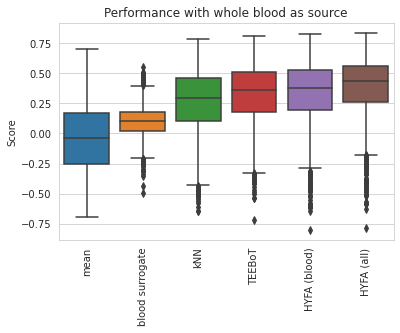

In [ ]:
results_df['score'] = pd.to_numeric(results_df['score'])
ranks = results_df.groupby('method')['score'].median().fillna(0).sort_values().index

sns.boxplot(x='method', y='score', data=results_df, order=ranks)
plt.xticks(rotation = 90)
plt.xlabel('')
plt.ylabel('Score')
plt.title('Performance with whole blood as source')
plt.savefig(f'{RESULTS_DIR}/figures/aggregated_scores_blood.pdf', bbox_inches='tight');

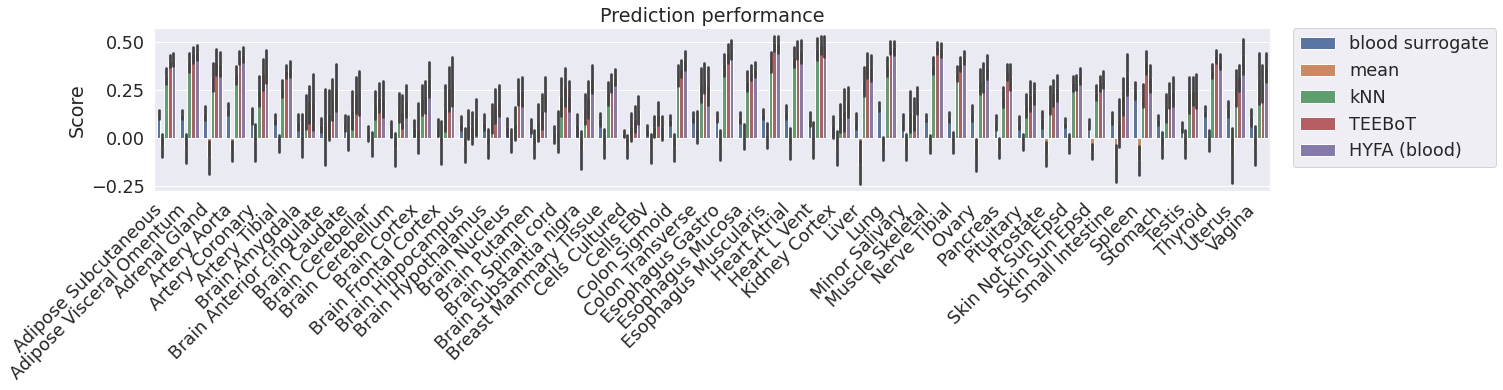

In [ ]:
sns.set(font_scale = 1.6)
plt.figure(figsize = (20, 3))
sns.barplot(y='score', x='target', hue='method',
            data=results_df[results_df['method'] != 'HYFA (all)'], order=np.unique(results_df['target']),
            )  # capsize = 0.1
plt.xticks(rotation=45, ha='right')

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.title('Prediction performance')
plt.xlabel('')
plt.ylabel('Score');
plt.savefig(f'{RESULTS_DIR}/figures/comparison_scores_pertissue_blood.pdf', bbox_inches='tight')

In [ ]:
results_df.to_csv(f'{RESULTS_DIR}/results_pertissue_blood.csv')

In [ ]:
# Sorted results
results_df_ = results_df[results_df['method'] == 'HYFA (blood)']
results_df_.groupby('target')['score'].mean().sort_values()

target
Cells EBV                   0.055601
Brain Hippocampus           0.113272
Cells Cultured              0.146610
Brain Amygdala              0.189233
Kidney Cortex               0.190552
Brain Cerebellum            0.191759
Minor Salivary              0.193284
Brain Hypothalamus          0.195194
Brain Cerebellar            0.209297
Brain Spinal cord           0.220145
Brain Putamen               0.228983
Pituitary                   0.234040
Brain Caudate               0.241153
Stomach                     0.241218
Brain Nucleus               0.243002
Testis                      0.247972
Brain Anterior cingulate    0.261638
Prostate                    0.262805
Colon Transverse            0.275517
Brain Frontal Cortex        0.297285
Skin Sun Epsd               0.304716
Brain Substantia nigra      0.307416
Brain Cortex                0.309529
Spleen                      0.313371
Breast Mammary Tissue       0.315988
Skin Not Sun Epsd           0.320327
Pancreas                    0.3

#### Comparison with TEEBoT across multiple tissues

In [ ]:
# Pre-load all data for kNN imputation
train_loader_all = DataLoader(train_dataset, batch_size=len(train_dataset), collate_fn=collate_fn, shuffle=False)
d = next(iter(train_loader_all))
y_observed = np.full((len(train_dataset), len(tissue_dict), config.G), np.nan)
y_observed[d.source['Participant ID'].numpy(), d.source['Tissue'].numpy(), :] = d.x_source
y_covs = d.node_features['Participant ID'].cpu().numpy()

In [ ]:
score_fn = pearson_correlation_score

source_tissues = ['Whole_Blood', 'Skin_Sun_Epsd', 'Skin_Not_Sun_Epsd', 'Adipose_Subcutaneous']  
ttissues = set(tissue_dict.keys())
ttissues = [t for t in ttissues if t not in source_tissues]
source_name = 'Accessible tissues'

results_df = pd.DataFrame([], columns=['score', 'source', 'target', 'method'])

for t in ttissues:
    print(', '.join(source_tissues), 'to', t)
    target_tissues = [t]
    target_name = t.replace('_', ' ')
    
    # Train set
    split_mask = train_mask
    valid_donors = []
    donors = adata[split_mask].obs['Participant ID'].unique()
    for donor in donors:
        donor_mask = adata[split_mask].obs['Participant ID'] == donor
        all_tissues_collected = all([t in adata[split_mask].obs[donor_mask]['Tissue'].values for t in source_tissues + target_tissues])
        if all_tissues_collected:
            valid_donors.append(donor)
    aux_train_dataset = HypergraphDataset(adata[split_mask],
                                    obs_source={'Tissue': source_tissues, 'Participant ID': valid_donors},
                                    obs_target={'Tissue': target_tissues, 'Participant ID': valid_donors},
                                    static=True, 
                                    verbose=True)
    aux_train_loader = DataLoader(aux_train_dataset, batch_size=len(aux_train_dataset), collate_fn=collate_fn, shuffle=False)
    
    # Validation set
    split_mask = np.logical_or(val_mask, test_mask)
    valid_donors = []
    donors = adata[split_mask].obs['Participant ID'].unique()
    for donor in donors:
        donor_mask = adata[split_mask].obs['Participant ID'] == donor
        all_tissues_collected = all([t in adata[split_mask].obs[donor_mask]['Tissue'].values for t in source_tissues + target_tissues])
        if all_tissues_collected:
            valid_donors.append(donor)
    
    aux_val_dataset = HypergraphDataset(adata[split_mask],
                                    obs_source={'Tissue': source_tissues, 'Participant ID': valid_donors},
                                    obs_target={'Tissue': target_tissues, 'Participant ID': valid_donors},
                                    static=True, 
                                    verbose=True)
    aux_val_loader = DataLoader(aux_val_dataset, batch_size=len(aux_val_dataset), collate_fn=collate_fn, shuffle=False)
    
    it = iter(aux_val_loader)
    val_d = next(it)
    patients_source_val = val_d.source['Participant ID'].cpu().numpy()
    
    print(source_tissues, target_name, len(np.unique(patients_source_val)))
    if len(np.unique(patients_source_val)) >= 25:  # combinations with > 25 patients
        # Reshape and concatenate multiple tissues
        it = iter(aux_train_loader)
        d = next(it)
        x_source = d.x_source.reshape(-1, len(source_tissues)* d.x_source.shape[-1])
        x_target = d.x_target  # .reshape(-1, len(source_tissues)* d.x_source.shape[-1])
        x_source_val = val_d.x_source.reshape(-1, len(source_tissues) * val_d.x_source.shape[-1])
        x_target_val = val_d.x_target # .reshape(-1, len(source_tissues) * val_d.x_source_val.shape[-1])
        x_source_covs = d.source_features['Participant ID'].cpu().numpy()
        x_source_val_covs  = val_d.source_features['Participant ID'].cpu().numpy()
        x_source_covs = x_source_covs.reshape(-1, len(source_tissues), x_source_covs.shape[-1])[:, 0, :]
        x_source_val_covs = x_source_val_covs.reshape(-1, len(source_tissues), x_source_val_covs.shape[-1])[:, 0, :]
        
        # Blood surrogate baseline
        blood_source_mask = val_d.source['Tissue'] == 48
        sample_scores = score_fn(x_target_val.numpy(), val_d.x_source[blood_source_mask].numpy(), sample_corr=True)
        gene_scores = score_fn(x_target_val.numpy(), val_d.x_source[blood_source_mask].numpy())
        print(f'Blood surrogate baseline: \n Mean score per gene: {gene_scores.mean()}. Mean score per sample: {sample_scores.mean()}')

        # Append results
        scores = sample_scores
        df_ = pd.DataFrame({'score': scores,
                            'source': [source_name] * len(scores),
                            'target': [target_name] * len(scores),
                            'method': ['Blood surrogate'] * len(scores)})
        results_df = pd.concat([results_df, df_])

        # Mean baseline
        means = d.x_target.mean(axis=0).numpy()
        y_test_pred = np.repeat(means[None, :], x_target_val.shape[0], axis=0)
        sample_scores = score_fn(x_target_val.numpy(), y_test_pred, sample_corr=True)
        # gene_scores = score_fn(x_target_val.numpy(), y_test_pred) # This is NaN as all samples are imputed with mean
        print(f'Mean baseline: \n Mean score per sample: {sample_scores.mean()}')

        # Append results
        scores = sample_scores
        df_ = pd.DataFrame({'score': scores,
                            'source': [source_name] * len(scores),
                            'target': [target_name] * len(scores),
                            'method': ['mean'] * len(scores)})
        results_df = pd.concat([results_df, df_])

        # KNN baseline
        x_train_knn = np.concatenate((x_source, x_target), axis=-1)
        test_nans = np.full((x_source_val.shape[0], x_target.shape[1]), np.nan)
        x_test_knn = np.concatenate((x_source_val, test_nans), axis=-1)
        x_knn = np.concatenate((x_train_knn, x_test_knn), axis=0)

        x_knn_covs = np.concatenate((x_source_covs, x_source_val_covs), axis=0)
        knn_imp = impute_knn(x_knn, covariates=x_knn_covs, k=20)
        knn_imp_ = knn_imp[x_source.shape[0]:, x_source.shape[1]:]
        sample_scores = score_fn(x_target_val.numpy(), knn_imp_, sample_corr=True)
        gene_scores = score_fn(x_target_val.numpy(), knn_imp_)
        print(f'kNN baseline: \n Mean score per gene: {gene_scores.mean()}. Mean score per sample: {sample_scores.mean()}')

        # Append results
        scores = sample_scores
        df_ = pd.DataFrame({'score': scores,
                            'source': [source_name] * len(scores),
                            'target': [target_name] * len(scores),
                            'method': ['kNN'] * len(scores)})
        results_df = pd.concat([results_df, df_])
        
        # KNN baseline with all (incomplete) samples
        # Fill in data
        y_val_knn = np.full((len(aux_val_dataset), len(tissue_dict), config.G), np.nan)
        y_val_knn[val_d.source['Participant ID'].numpy(), val_d.source['Tissue'].numpy(), :] = val_d.x_source
        
        # Select accessible tissues and target tissue
        tissue_idxs = [tissue_dict[t] for t in source_tissues] + [tissue_dict[t] for t in target_tissues]
        y_observed_ = y_observed[:, tissue_idxs, :]
        y_val_knn = y_val_knn[:, tissue_idxs, :]
        y_covs_val_knn = val_d.node_features['Participant ID'].cpu().numpy()        
        y_observed_ = np.concatenate((y_observed_, y_val_knn), axis=0)
        y_covs_ =  np.concatenate((y_covs, y_covs_val_knn), axis=0)
        y_imp_knn = impute_knn(y_observed_, y_covs_, k=20)
        y_imp_knn_ = y_imp_knn[-y_val_knn.shape[0]:, -1]  # Selects target tissue predictions
        sample_scores = score_fn(x_target_val.numpy(), y_imp_knn_, sample_corr=True)
        gene_scores = score_fn(x_target_val.numpy(), y_imp_knn_)
        print(f'kNN (all incomplete) baseline: \n Mean score per gene: {gene_scores.mean()}. Mean score per sample: {sample_scores.mean()}')
        
        # Append results
        scores = sample_scores
        df_ = pd.DataFrame({'score': scores,
                            'source': [source_name] * len(scores),
                            'target': [target_name] * len(scores),
                            'method': ['kNN (all incomplete)'] * len(scores)})
        results_df = pd.concat([results_df, df_])
        
        # TEEBoT
        x_target_pred = PCA_linear_regression_baseline_v1(x_source, x_target, x_source_val,
                                                          x_source_covs=x_source_covs,
                                                          x_source_test_covs=x_source_val_covs)
        gene_scores = score_fn(x_target_val.numpy(), x_target_pred)
        sample_scores = score_fn(x_target_val.numpy(), x_target_pred, sample_corr=True)
        print(f'TEEBoT regression baseline: \n Mean score per gene: {gene_scores.mean()}. Mean score per sample: {sample_scores.mean()}')

        # Store results
        scores = sample_scores
        df_ = pd.DataFrame({'score': sample_scores,
                            'source': [source_name] * len(scores),
                            'target': [target_name] * len(scores),
                            'method': ['TEEBoT'] * len(scores)})
        results_df = pd.concat([results_df, df_])

        # Hypergraph
        with torch.no_grad():
            d = next(iter(aux_val_loader))
            out, node_features = forward(d, model, device, preprocess_fn=None)
            y_pred = out['px_rate'].cpu().numpy()
            y_ = d.x_target.cpu().numpy()
        assert np.allclose(y_, x_target_val)

        gene_scores = score_fn(x_target_val.numpy(), y_pred)
        sample_scores = score_fn(x_target_val.numpy(), y_pred, sample_corr=True)
        print(f'Hypergraph neural network (accessible): \n Mean score per gene: {gene_scores.mean()}. Mean score per sample: {sample_scores.mean()}')

        # Store results
        scores = sample_scores
        df_ = pd.DataFrame({'score': sample_scores,
                            'source': [source_name] * len(scores),
                            'target': [target_name] * len(scores),
                            'method': ['HYFA (accessible)'] * len(scores)})
        results_df = pd.concat([results_df, df_])
        
        # Hypergraph baseline (all tissues)
        # Select same set of individuals
        aux_val_dataset_ = HypergraphDataset(adata[split_mask],
                                          obs_source={'Participant ID': list(aux_val_dataset.donor_map.values())},
                                          obs_target={'Tissue': [t]})
        aux_val_loader_ = DataLoader(aux_val_dataset_, batch_size=len(aux_val_dataset_), collate_fn=collate_fn, shuffle=False)

        # Compute predictions and score
        model.eval()
        with torch.no_grad():
            d = next(iter(aux_val_loader_))

            out, node_features = forward(d, model, device, preprocess_fn=None)
            y_val_pred = out['px_rate'].cpu().numpy()  # torch.distributions.normal.Normal(loc=out['px_rate'], scale=out['px_r']).mean.cpu().numpy()
            y_test_ = d.x_target.cpu().numpy()

        sample_scores = score_fn(x_target_val.numpy(), y_val_pred, sample_corr=True)
        gene_scores = score_fn(x_target_val.numpy(), y_val_pred)
        print(f'Hypergraph neural network (all): \n Mean score per gene: {gene_scores.mean()}. Mean score per sample: {sample_scores.mean()}')

        # Append results
        scores = sample_scores
        df_ = pd.DataFrame({'score': scores,
                            'source': [source_name] * len(scores),
                            'target': [target_name] * len(scores),
                            'method': ['HYFA (all)'] * len(scores)})
        results_df = pd.concat([results_df, df_])  

Whole_Blood, Skin_Sun_Epsd, Skin_Not_Sun_Epsd, Adipose_Subcutaneous to Pituitary
Selected 184 source and 46 target samples of 46 unique donors
Selected 200 source and 50 target samples of 50 unique donors
['Whole_Blood', 'Skin_Sun_Epsd', 'Skin_Not_Sun_Epsd', 'Adipose_Subcutaneous'] Pituitary 50
Blood surrogate baseline: 
 Mean score per gene: 0.10160010308027267. Mean score per sample: 0.09197278320789337
Mean baseline: 
 Mean score per sample: 0.014818418771028519
kNN baseline: 
 Mean score per gene: 0.1610818394956618. Mean score per sample: 0.14249498397931512
kNN (all incomplete) baseline: 
 Mean score per gene: 0.09363109850369584. Mean score per sample: 0.06404439203496089
TEEBoT regression baseline: 
 Mean score per gene: 0.1518411528906685. Mean score per sample: 0.1378682542061573
Hypergraph neural network (accessible): 
 Mean score per gene: 0.2471914142370224. Mean score per sample: 0.23560857772827148
Hypergraph neural network (all): 
 Mean score per gene: 0.290490686893463

['Whole_Blood', 'Skin_Sun_Epsd', 'Skin_Not_Sun_Epsd', 'Adipose_Subcutaneous'] Heart Atrial 67
Blood surrogate baseline: 
 Mean score per gene: 0.09907890111207962. Mean score per sample: 0.11591219902038574
Mean baseline: 
 Mean score per sample: -0.07209058105945587
kNN baseline: 
 Mean score per gene: 0.35488936681349875. Mean score per sample: 0.36070360334127816
kNN (all incomplete) baseline: 
 Mean score per gene: 0.062296186691017. Mean score per sample: -0.039216879576767796
TEEBoT regression baseline: 
 Mean score per gene: 0.33911445983539484. Mean score per sample: 0.32053668677845426
Hypergraph neural network (accessible): 
 Mean score per gene: 0.4428681433200836. Mean score per sample: 0.4550083577632904
Hypergraph neural network (all): 
 Mean score per gene: 0.46726781129837036. Mean score per sample: 0.47564753890037537
Whole_Blood, Skin_Sun_Epsd, Skin_Not_Sun_Epsd, Adipose_Subcutaneous to Colon_Transverse
Selected 300 source and 75 target samples of 75 unique donors
Sel

Selected 84 source and 21 target samples of 21 unique donors
Selected 80 source and 20 target samples of 20 unique donors
['Whole_Blood', 'Skin_Sun_Epsd', 'Skin_Not_Sun_Epsd', 'Adipose_Subcutaneous'] Brain Anterior cingulate 20
Whole_Blood, Skin_Sun_Epsd, Skin_Not_Sun_Epsd, Adipose_Subcutaneous to Artery_Tibial
Selected 468 source and 117 target samples of 117 unique donors
Selected 372 source and 93 target samples of 93 unique donors
['Whole_Blood', 'Skin_Sun_Epsd', 'Skin_Not_Sun_Epsd', 'Adipose_Subcutaneous'] Artery Tibial 93
Blood surrogate baseline: 
 Mean score per gene: 0.09442698955535889. Mean score per sample: 0.10328797250986099
Mean baseline: 
 Mean score per sample: 0.057288091629743576
kNN baseline: 
 Mean score per gene: 0.3004060092594959. Mean score per sample: 0.31958493942954136
kNN (all incomplete) baseline: 
 Mean score per gene: 0.056036988104053054. Mean score per sample: 0.03084422884974269
TEEBoT regression baseline: 
 Mean score per gene: 0.32765676967969865. M

Selected 268 source and 67 target samples of 67 unique donors
Selected 244 source and 61 target samples of 61 unique donors
['Whole_Blood', 'Skin_Sun_Epsd', 'Skin_Not_Sun_Epsd', 'Adipose_Subcutaneous'] Testis 61
Blood surrogate baseline: 
 Mean score per gene: 0.05329132080078125. Mean score per sample: 0.05079710856080055
Mean baseline: 
 Mean score per sample: -0.02339196391403675
kNN baseline: 
 Mean score per gene: 0.1808754689837246. Mean score per sample: 0.18702152243608722
kNN (all incomplete) baseline: 
 Mean score per gene: 0.18238701419514605. Mean score per sample: 0.0626603193192607
TEEBoT regression baseline: 
 Mean score per gene: 0.22259883779873607. Mean score per sample: 0.18969792779664865
Hypergraph neural network (accessible): 
 Mean score per gene: 0.34289678931236267. Mean score per sample: 0.308925062417984
Hypergraph neural network (all): 
 Mean score per gene: 0.30345579981803894. Mean score per sample: 0.2696773111820221
Whole_Blood, Skin_Sun_Epsd, Skin_Not_S

kNN baseline: 
 Mean score per gene: 0.04852413708165659. Mean score per sample: 0.08358897389251693
kNN (all incomplete) baseline: 
 Mean score per gene: 0.028556348630686703. Mean score per sample: -0.01105586191798805
TEEBoT regression baseline: 
 Mean score per gene: 0.0069778679593074915. Mean score per sample: 0.011254659352390355
Hypergraph neural network (accessible): 
 Mean score per gene: 0.12556692957878113. Mean score per sample: 0.0899297446012497
Hypergraph neural network (all): 
 Mean score per gene: 0.12363304942846298. Mean score per sample: 0.09924657642841339
Whole_Blood, Skin_Sun_Epsd, Skin_Not_Sun_Epsd, Adipose_Subcutaneous to Breast_Mammary_Tissue
Selected 404 source and 101 target samples of 101 unique donors
Selected 264 source and 66 target samples of 66 unique donors
['Whole_Blood', 'Skin_Sun_Epsd', 'Skin_Not_Sun_Epsd', 'Adipose_Subcutaneous'] Breast Mammary Tissue 66
Blood surrogate baseline: 
 Mean score per gene: 0.10162339359521866. Mean score per sample: 

Blood surrogate baseline: 
 Mean score per gene: 0.11868244409561157. Mean score per sample: 0.11969432234764099
Mean baseline: 
 Mean score per sample: 0.05029886215925217
kNN baseline: 
 Mean score per gene: 0.11744234360517354. Mean score per sample: 0.0837069566580789
kNN (all incomplete) baseline: 
 Mean score per gene: -0.023851267380485593. Mean score per sample: 0.04545881314131392
TEEBoT regression baseline: 
 Mean score per gene: 0.021576422785625347. Mean score per sample: 0.059270788020956235
Hypergraph neural network (accessible): 
 Mean score per gene: 0.24491392076015472. Mean score per sample: 0.22023756802082062
Hypergraph neural network (all): 
 Mean score per gene: 0.2887367308139801. Mean score per sample: 0.2708345949649811


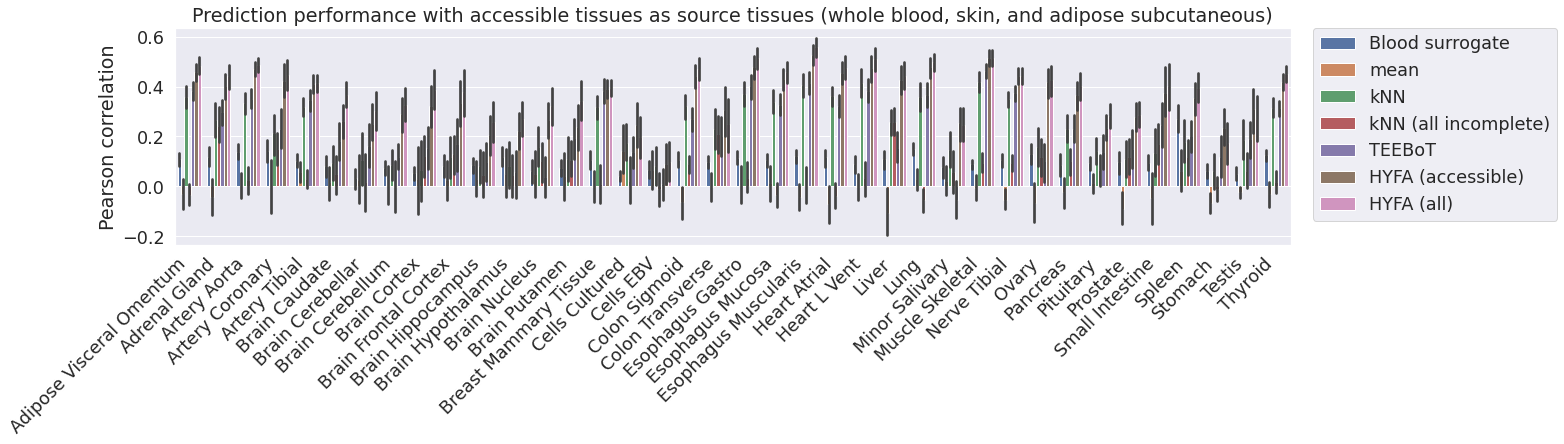

In [ ]:
sns.set(font_scale = 1.6)
plt.figure(figsize = (20, 4))
sns.barplot(y='score', x='target', hue='method', data=results_df, order=np.unique(results_df['target']))
plt.xticks(rotation=45, ha='right')

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.title('Prediction performance with accessible tissues as source tissues (whole blood, skin, and adipose subcutaneous)')
plt.xlabel('')
plt.ylabel('Pearson correlation');

plt.savefig(f'{RESULTS_DIR}/figures/comparison_accessible_scores_valtest.pdf', bbox_inches='tight')

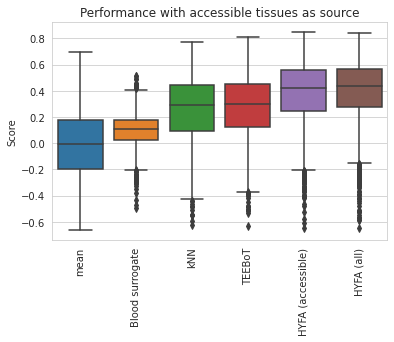

In [ ]:
sns.reset_orig()
sns.set_style("whitegrid")

results_df['score'] = pd.to_numeric(results_df['score'])
ranks = results_df.groupby('method')['score'].median().fillna(0).sort_values().index

sns.boxplot(x='method', y='score', data=results_df, order=ranks)
plt.xticks(rotation = 90)
plt.xlabel('')
plt.ylabel('Score')
plt.title('Performance with accessible tissues as source')
plt.savefig(f'{RESULTS_DIR}/figures/aggregated_scores_accessible.pdf', bbox_inches='tight');

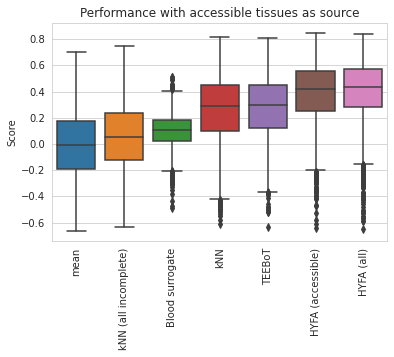

In [ ]:
sns.reset_orig()
sns.set_style("whitegrid")

results_df['score'] = pd.to_numeric(results_df['score'])
ranks = results_df.groupby('method')['score'].median().fillna(0).sort_values().index

sns.boxplot(x='method', y='score', data=results_df, order=ranks)
plt.xticks(rotation = 90)
plt.xlabel('')
plt.ylabel('Score')
plt.title('Performance with accessible tissues as source')
plt.savefig(f'{RESULTS_DIR}/figures/aggregated_scores_accessible.pdf', bbox_inches='tight');

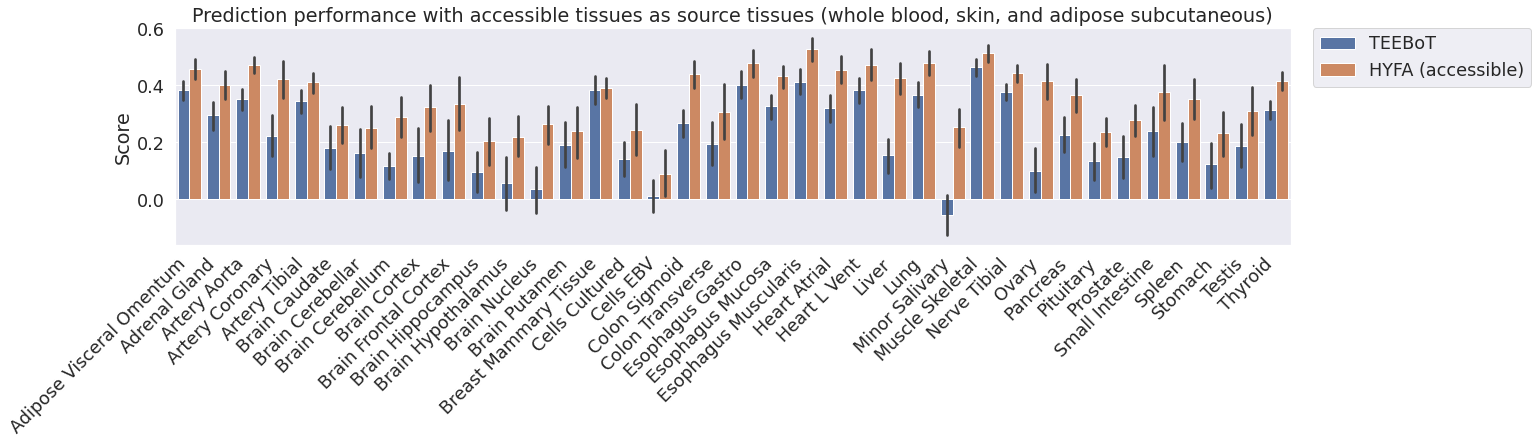

In [ ]:
sns.set(font_scale = 1.6)
plt.figure(figsize = (20, 4))
results_df_ = results_df[results_df['method'].isin(['TEEBoT', 'HYFA (accessible)'])]
sns.barplot(y='score', x='target', hue='method', data=results_df_, order=np.unique(results_df_['target']))
plt.xticks(rotation=45, ha='right')

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.title('Prediction performance with accessible tissues as source tissues (whole blood, skin, and adipose subcutaneous)')
plt.xlabel('')
plt.ylabel('Score');

plt.savefig(f'{RESULTS_DIR}/figures/comparison_scores_valtest_HYFA_accessible.pdf', bbox_inches='tight')

In [ ]:
results_df.to_csv(f'{RESULTS_DIR}/results_pertissue_sources_accessible.csv')

In [ ]:
baseline_means = results_df[results_df['method'] == 'TEEBoT'].groupby('target')['score'].mean()
ours_means = results_df[results_df['method'] == 'HYFA (accessible)'].groupby('target')['score'].mean()
(ours_means > baseline_means).sum(), ours_means.size

(38, 38)

#### Increase in performance when multiple accessible tissues are used as source

In [ ]:
score_fn = pearson_correlation_score

source_tissues = ['Whole_Blood', 'Skin_Sun_Epsd', 'Skin_Not_Sun_Epsd', 'Adipose_Subcutaneous']
source_tissues_idxs = [tissue_dict[t] for t in source_tissues]
names = [t.replace('_', ' ') for t in source_tissues] + ['Accessible All']

scores_col = []
source_col = []
target_col = []

# Target tissue
ttissues = set(tissue_dict.keys()) # - set(['Testis', 'Cells_Cultured'])
ttissues = [t for t in ttissues if t not in source_tissues]

for t in ttissues:
    target_tissues = [t]
    target_name = t.replace('_', ' ')
    
    # Get data
    # split_mask = val_mask
    split_mask = test_mask # np.logical_or(val_mask, test_mask)
    
    donors = adata[split_mask].obs['Participant ID'].unique()

    valid_donors = []
    for donor in donors:
        donor_mask = adata[split_mask].obs['Participant ID'] == donor
        all_tissues_collected = all([t in adata[split_mask].obs[donor_mask]['Tissue'].values for t in source_tissues + target_tissues])
        if all_tissues_collected:
            valid_donors.append(donor)
    
    aux_dataset = HypergraphDataset(adata[split_mask],
                                    obs_source={'Tissue': source_tissues, 'Participant ID': valid_donors},
                                    obs_target={'Tissue': target_tissues, 'Participant ID': valid_donors},
                                    static=True, 
                                    verbose=True)
    print(len(aux_dataset))
    aux_loader = DataLoader(aux_dataset, batch_size=len(aux_dataset), collate_fn=collate_fn, shuffle=False)
    
    it = iter(aux_loader)
    d = next(it)
    patients_source = d.source['Participant ID']
    tissues_source = d.source['Tissue']
    
    print(source_tissues, target_name, len(np.unique(patients_source)))
    if len(np.unique(patients_source)) >= 25:
        # Evaluate performance when increasingly adding more tissue types
        cum_source_tissues_idxs = []
        # selected_tissues = [[tissue_dict[t]] for t in source_tissues] + [[tissue_dict[t] for t in source_tissues]]
        selected_tissues = [[t] for t in source_tissues] + [source_tissues]
        print(selected_tissues)
        
        for source_t, name in zip(selected_tissues, names):
            cum_source_tissues_idxs = source_t
            
            # print(source_t, target_tissues)
            # Select samples from subset of individuals having all selected tissues
            aux_dataset_ = HypergraphDataset(adata = aux_dataset.adata_source,
                                             adata_target = aux_dataset.adata_target,
                                             obs_source={'Tissue': source_t},
                                             obs_target={'Tissue': target_tissues},
                                             static=True)
            aux_loader_ = DataLoader(aux_dataset_, batch_size=len(aux_dataset_), collate_fn=collate_fn, shuffle=False)

            with torch.no_grad():
                d = next(iter(aux_loader_))
                out, node_features = forward(d, model, device, preprocess_fn=None)
                y_pred = out['px_rate'].cpu().numpy()
                y_ = d.x_target.cpu().numpy()
                
            gene_scores = score_fn(y_, y_pred)
            sample_scores = score_fn(y_, y_pred, sample_corr=True)
            print(f'Hypergraph neural network: \n Mean score per gene: {gene_scores.mean()}. Mean score per sample: {sample_scores.mean()}')

            scores = sample_scores
            scores_col.extend(scores)
            source_col.extend([name] * len(scores))
            target_col.extend([target_name] * len(scores))

Selected 28 source and 7 target samples of 7 unique donors
7
['Whole_Blood', 'Skin_Sun_Epsd', 'Skin_Not_Sun_Epsd', 'Adipose_Subcutaneous'] Brain Anterior cingulate 7
Selected 116 source and 29 target samples of 29 unique donors
29
['Whole_Blood', 'Skin_Sun_Epsd', 'Skin_Not_Sun_Epsd', 'Adipose_Subcutaneous'] Stomach 29
[['Whole_Blood'], ['Skin_Sun_Epsd'], ['Skin_Not_Sun_Epsd'], ['Adipose_Subcutaneous'], ['Whole_Blood', 'Skin_Sun_Epsd', 'Skin_Not_Sun_Epsd', 'Adipose_Subcutaneous']]
Hypergraph neural network: 
 Mean score per gene: 0.25529900193214417. Mean score per sample: 0.23218436539173126
Hypergraph neural network: 
 Mean score per gene: 0.11322974413633347. Mean score per sample: 0.13241592049598694
Hypergraph neural network: 
 Mean score per gene: 0.19966480135917664. Mean score per sample: 0.19628258049488068
Hypergraph neural network: 
 Mean score per gene: 0.19374097883701324. Mean score per sample: 0.17923282086849213
Hypergraph neural network: 
 Mean score per gene: 0.2394625

Selected 84 source and 21 target samples of 21 unique donors
21
['Whole_Blood', 'Skin_Sun_Epsd', 'Skin_Not_Sun_Epsd', 'Adipose_Subcutaneous'] Cells EBV 21
Selected 84 source and 21 target samples of 21 unique donors
21
['Whole_Blood', 'Skin_Sun_Epsd', 'Skin_Not_Sun_Epsd', 'Adipose_Subcutaneous'] Small Intestine 21
Selected 148 source and 37 target samples of 37 unique donors
37
['Whole_Blood', 'Skin_Sun_Epsd', 'Skin_Not_Sun_Epsd', 'Adipose_Subcutaneous'] Esophagus Mucosa 37
[['Whole_Blood'], ['Skin_Sun_Epsd'], ['Skin_Not_Sun_Epsd'], ['Adipose_Subcutaneous'], ['Whole_Blood', 'Skin_Sun_Epsd', 'Skin_Not_Sun_Epsd', 'Adipose_Subcutaneous']]
Hypergraph neural network: 
 Mean score per gene: 0.3712947964668274. Mean score per sample: 0.380026251077652
Hypergraph neural network: 
 Mean score per gene: 0.3474847972393036. Mean score per sample: 0.36671966314315796
Hypergraph neural network: 
 Mean score per gene: 0.359973281621933. Mean score per sample: 0.39693745970726013
Hypergraph neural ne

Hypergraph neural network: 
 Mean score per gene: 0.18021225929260254. Mean score per sample: 0.18534274399280548
Hypergraph neural network: 
 Mean score per gene: 0.22463631629943848. Mean score per sample: 0.21171441674232483
Hypergraph neural network: 
 Mean score per gene: 0.20400378108024597. Mean score per sample: 0.19643908739089966
Hypergraph neural network: 
 Mean score per gene: 0.2659114599227905. Mean score per sample: 0.25133347511291504
Selected 48 source and 12 target samples of 12 unique donors
12
['Whole_Blood', 'Skin_Sun_Epsd', 'Skin_Not_Sun_Epsd', 'Adipose_Subcutaneous'] Vagina 12
Selected 28 source and 7 target samples of 7 unique donors
7
['Whole_Blood', 'Skin_Sun_Epsd', 'Skin_Not_Sun_Epsd', 'Adipose_Subcutaneous'] Brain Substantia nigra 7
Selected 76 source and 19 target samples of 19 unique donors
19
['Whole_Blood', 'Skin_Sun_Epsd', 'Skin_Not_Sun_Epsd', 'Adipose_Subcutaneous'] Pancreas 19
Selected 52 source and 13 target samples of 13 unique donors
13
['Whole_Blo

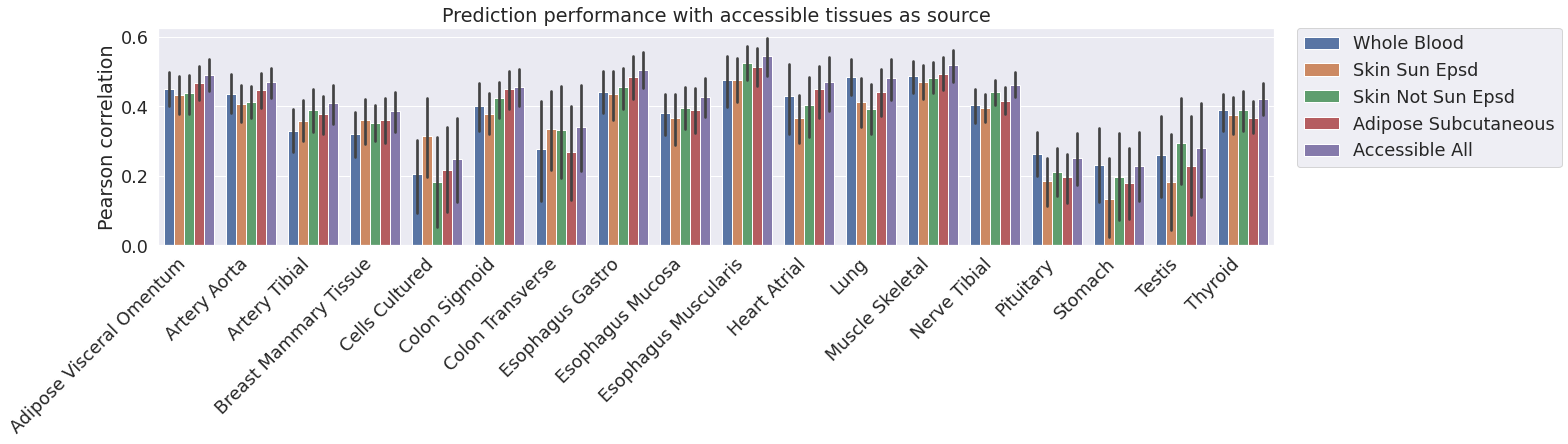

In [ ]:
results_df = pd.DataFrame({'score': scores_col, 'source': source_col, 'target': target_col})

sns.set(font_scale = 1.6)
plt.figure(figsize = (20, 4))
sns.barplot(y='score', x='target', hue='source', data=results_df, order=np.unique(results_df['target']))
plt.xticks(rotation=45, ha='right')

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)

plt.title('Prediction performance with accessible tissues as source')
plt.xlabel('')
plt.ylabel('Pearson correlation');

plt.savefig(f'{RESULTS_DIR}/figures/scores_pertissue_HYFA_accessible.pdf', bbox_inches='tight')

In [ ]:
results_df.to_csv(f'{RESULTS_DIR}/results_pertissue_HYFA_sources_accessible.csv')

In [ ]:
diffs_df = pd.DataFrame()
for t in results_df['target'].unique():
    mean_1 = results_df[(results_df['target'] == t) & (results_df['source'] == 'Whole Blood')]['score'].mean()
    mean_2 = results_df[(results_df['target'] == t) & (results_df['source'] == 'Accessible All')]['score'].mean()
    # print(t, mean_2 - mean_1)
    diffs_df = pd.concat([diffs_df, pd.DataFrame([[t, mean_2 - mean_1]])])
diffs_df.sort_values(by=1, ascending=False)

,0,1
0,Artery Tibial,0.079605
0,Esophagus Muscularis,0.068761
0,Breast Mammary Tissue,0.067480
0,Colon Transverse,0.064921
0,Esophagus Gastro,0.061533
0,Nerve Tibial,0.059013
0,Colon Sigmoid,0.056092
0,Esophagus Mucosa,0.048158
0,Cells Cultured,0.044525
0,Heart Atrial,0.040042


#### Brain-gut connection?

In [ ]:
score_fn = r2_score # pearson_correlation_score

# Select source and target tissues
source_tissues = ['Esophagus_Gastro']  # , 'Colon_Sigmoid'
ttissues = set(tissue_dict.keys())
ttissues = [t for t in ttissues if t not in source_tissues and t.startswith('Brain')]
source_name = ', '.join([t.replace('_', ' ') for t in source_tissues])

results_df = pd.DataFrame([], columns=['score', 'source', 'target', 'method'])
gene_scores_tt = {}
preds_per_tissue = {}
for t in ttissues:
    target_tissues = [t]
    target_name = t.replace('_', ' ')
    
    split_mask = np.logical_or(val_mask, test_mask)  # Using both validation and test individuals
    
    # Hypergraph
    try:
        aux_dataset = HypergraphDataset(adata[split_mask],
                                            obs_source={'Tissue': source_tissues},
                                            obs_target={'Tissue': target_tissues})
        aux_loader = DataLoader(aux_dataset, batch_size=len(aux_dataset), collate_fn=collate_fn, shuffle=False)
        
        with torch.no_grad():
            d = next(iter(aux_loader))
            out, node_features = forward(d, model, device, preprocess_fn=None)
            y_pred = out['px_rate'].cpu().numpy()
            y_ = d.x_target.cpu().numpy()
        
        # x_source_val_, x_target_val_, _, _, patients_source, _ = examples
        patients_source = d.source['Participant ID']

        if len(patients_source.unique()) > 10:
            print(', '.join(source_tissues), 'to', t, '. Intersection: ', len(patients_source.unique()))
            gene_scores = score_fn(y_, y_pred)
            sample_scores = score_fn(y_, y_pred, sample_corr=True)
            print(f'Hypergraph neural network: \n Mean score per gene: {gene_scores.mean()}. Mean score per sample: {sample_scores.mean()}')

            # Store results
            scores = sample_scores
            df_ = pd.DataFrame({'score': sample_scores,
                                'source': [source_name] * len(scores),
                                'target': [target_name] * len(scores),
                                'method': ['ours'] * len(scores)})
            results_df = pd.concat([results_df, df_])
            
            # Store gene scores for each target tissue
            gene_scores_tt[t] = gene_scores
            
            # Store predictions per target tissue
            preds_per_tissue[t] = (y_, y_pred)
            
    except ValueError:
        pass

Esophagus_Gastro to Brain_Caudate . Intersection:  27
Hypergraph neural network: 
 Mean score per gene: -0.1297236979007721. Mean score per sample: -0.07919002324342728
Esophagus_Gastro to Brain_Hippocampus . Intersection:  25
Hypergraph neural network: 
 Mean score per gene: -0.04366635903716087. Mean score per sample: 0.023033689707517624
Esophagus_Gastro to Brain_Cerebellar . Intersection:  26
Hypergraph neural network: 
 Mean score per gene: 0.05165591463446617. Mean score per sample: 0.04902385175228119
Esophagus_Gastro to Brain_Cerebellum . Intersection:  36
Hypergraph neural network: 
 Mean score per gene: -0.018421554937958717. Mean score per sample: 0.02121572010219097
Esophagus_Gastro to Brain_Anterior_cingulate . Intersection:  24
Hypergraph neural network: 
 Mean score per gene: -0.11841189116239548. Mean score per sample: -0.09468013793230057
Esophagus_Gastro to Brain_Spinal_cord . Intersection:  24
Hypergraph neural network: 
 Mean score per gene: 0.023599328473210335. Me

/home/rv340/anaconda3/envs/multitissue/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
/home/rv340/anaconda3/envs/multitissue/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)


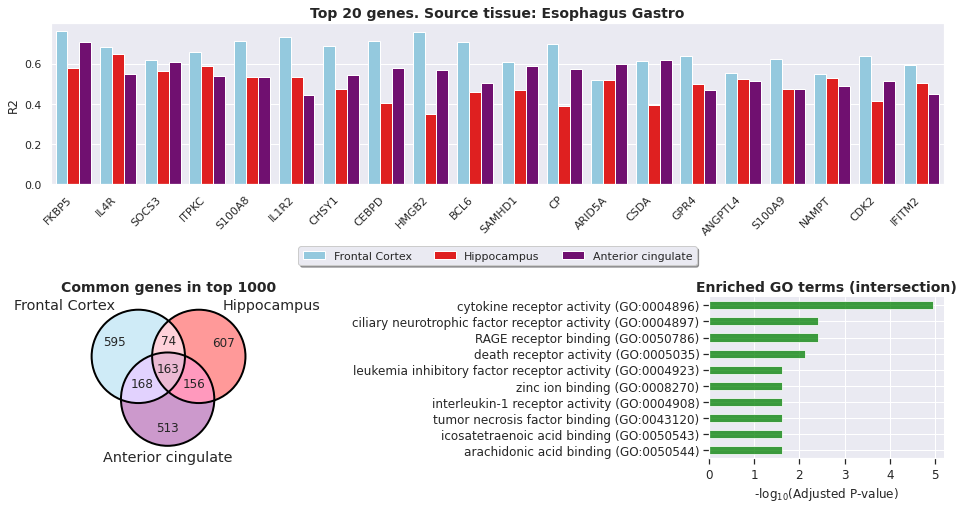

In [ ]:
topk_barplot = 20
topk_intersect = 1000
source = 'Esophagus_Gastro'
targets = ['Brain_Frontal_Cortex', 'Brain_Hippocampus', 'Brain_Anterior_cingulate']

sns.set(font_scale = 1.)
fig = plt.figure(figsize=(16, 8))

# Create dataframe
df = pd.DataFrame(gene_scores_tt)
df = df[targets]
df.columns = [col.replace('_', ' ') for col in df.columns]
df.columns = [name.split('Brain ')[-1] for name in df.columns]
df.index = adata.var['Symbol'].values  # gene_symbols

set_colors = ('skyblue', 'red', 'purple')
palette = {t: c for t, c in zip(df.columns, set_colors)}

# Find top topk_intersect genes from each target tissue and compute common genes
top_genes = []
names = df.columns
for t in names:
    top_genes.append(set(df[t].sort_values(ascending=False).index.values[:topk_intersect])) 
common_genes = [set.intersection(*top_genes)]

# Plot barplot with top topk_barplot genes
ax = plt.subplot(2, 1, 1)
ranks = df.mean(axis=1).sort_values(ascending=False)
gene_barplot_df = df.loc[ranks.index[:topk_barplot]]
gene_barplot_df = gene_barplot_df.reset_index().melt(id_vars='index')
sns.barplot(x='index', y='value', hue='variable', data=gene_barplot_df, ax=ax, palette=palette)
plt.ylabel('R2')
plt.xlabel('');
plt.xticks(rotation=45, ha='right')

# fig.subplots_adjust(top=0.9)
# plt.suptitle('Top 20 genes'.format(source_name), fontweight="bold")
plt.title('Top 20 genes. Source tissue: {}'.format(source_name), fontsize=14, fontweight='bold')
# plt.legend(bbox_to_anchor=(1.02, 1), loc=10, borderaxespad=0., title='Target tissue')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35),  shadow=True, ncol=5)

# plt.savefig('overleaf/figures/{}-{}.pdf'.format(source_name, '-'.join(targets)), bbox_inches='tight');

# Plot barplot with top topk_barplot genes
ax = plt.subplot(2, 2, 3)
plt.title('Common genes in top 1000', fontsize=14, fontweight='bold')
venn3(top_genes, set_labels = [name.split('Brain ')[-1] for name in names], set_colors=set_colors)
c = venn3_circles(top_genes)

# Enrichment plot
ax = plt.subplot(2, 2, 4)
enr = gp.enrichr(gene_list=list(common_genes[0]),
                 gene_sets=['GO_Biological_Process_2021','GO_Molecular_Function_2021'],
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 description='test_name',
                 # outdir='test/enrichr_kegg',
                 # no_plot=True,
                 cutoff=0.05 # test dataset, use lower value from range(0,1)
                )
enr_barplot(enr.res2d, figsize=(4, 3), ax=ax, color='green')

plt.title('Enriched GO terms (intersection)', fontsize=14, fontweight='bold')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1.8, hspace=0.7)

plt.savefig('{}/figures/enrichment_combined_{}-{}.pdf'.format(RESULTS_DIR, source_name, '-'.join(targets)), bbox_inches='tight');


In [ ]:
df.to_csv('{}/r2scores_{}-{}.csv'.format(RESULTS_DIR, source, '-'.join(targets)))

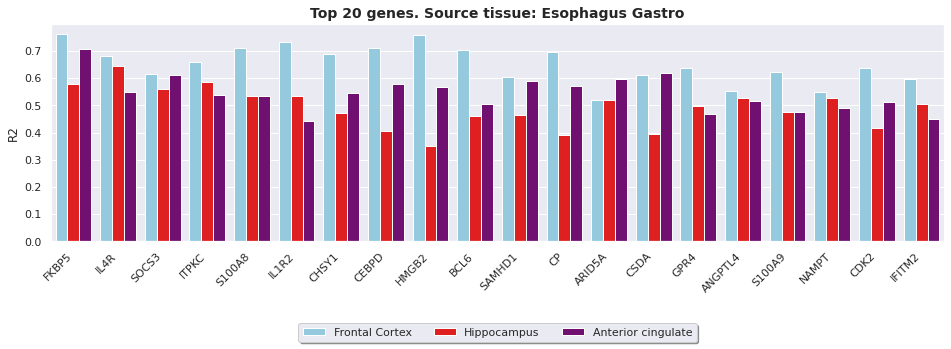

In [ ]:
plt.figure(figsize=(16, 4))
ax = plt.gca()
ranks = df.mean(axis=1).sort_values(ascending=False)
gene_barplot_df = df.loc[ranks.index[:topk_barplot]]
gene_barplot_df = gene_barplot_df.reset_index().melt(id_vars='index')
sns.barplot(x='index', y='value', hue='variable', data=gene_barplot_df, ax=ax, palette=palette)
plt.ylabel('R2')
plt.xlabel('');
plt.xticks(rotation=45, ha='right')

# fig.subplots_adjust(top=0.9)
# plt.suptitle('Top 20 genes'.format(source_name), fontweight="bold")
plt.title('Top 20 genes. Source tissue: {}'.format(source_name), fontsize=14, fontweight='bold')
# plt.legend(bbox_to_anchor=(1.02, 1), loc=10, borderaxespad=0., title='Target tissue')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35),  shadow=True, ncol=5)
plt.savefig('{}/figures/top_20_genes_{}-{}.pdf'.format(RESULTS_DIR, source_name, '-'.join(targets)), bbox_inches='tight');

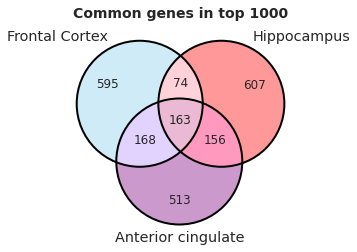

In [ ]:
# Plot barplot with top topk_barplot genes
plt.figure(figsize=(6, 4))
plt.title('Common genes in top 1000', fontsize=14, fontweight='bold')
venn3(top_genes, set_labels = [name.split('Brain ')[-1] for name in names], set_colors=set_colors)
c = venn3_circles(top_genes)
plt.savefig('{}/figures/venn_{}-{}.pdf'.format(RESULTS_DIR, source_name, '-'.join(targets)), bbox_inches='tight');

/home/rv340/anaconda3/envs/multitissue/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
/home/rv340/anaconda3/envs/multitissue/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)


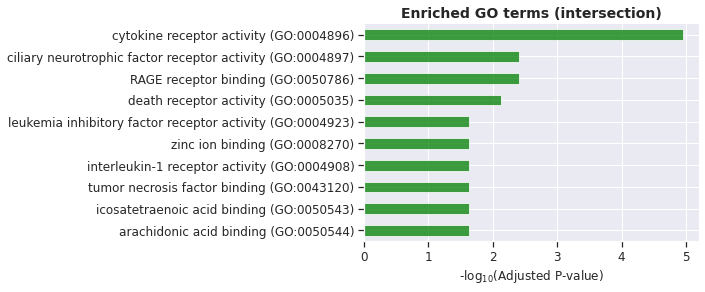

In [ ]:
# Enrichment plot
plt.figure(figsize=(6, 4))
ax = plt.gca()
enr = gp.enrichr(gene_list=list(common_genes[0]),
                 gene_sets=['GO_Biological_Process_2021','GO_Molecular_Function_2021'],
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 description='test_name',
                 # outdir='test/enrichr_kegg',
                 # no_plot=True,
                 cutoff=0.05 # test dataset, use lower value from range(0,1)
                )
enr_barplot(enr.res2d, figsize=(4, 3), ax=ax, color='green')

plt.title('Enriched GO terms (intersection)', fontsize=14, fontweight='bold')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1.8, hspace=0.7)

plt.savefig('{}/figures/enrichment_{}-{}.pdf'.format(RESULTS_DIR, source_name, '-'.join(targets)), bbox_inches='tight');

#### Metagene-factors GSEA

In [ ]:
library = blitz.enrichr.get_library('KEGG_2021_Human')

In [ ]:
metagene_w = model.metagenes_encoder.encoder[0].weight.detach().cpu().numpy()
metagene_w = metagene_w.reshape((config.meta_G, -1, config.G))

In [ ]:
n_factors = config.d_edge_attr
n_metagenes = config.meta_G

results_df = pd.DataFrame()
for f in range(n_factors):
    print(f'Factor={f}')
    for m in range(n_metagenes):
        gene_idxs = np.argsort(metagene_w[m, f, :])[::-1]
        gene_names = adata.var['Symbol'][gene_idxs].values
        gene_values = metagene_w[m, f, gene_idxs]
        signature = pd.DataFrame({0: gene_names, 1: gene_values})
        
        result = blitz.gsea(signature, library, permutations=2000, signature_cache=True)
        result['Factor'] = f
        result['Metagene'] = m
        results_df = pd.concat([results_df, result], axis=0)

Factor=0
Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 836.97it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 854.51it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 845.79it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 791.93it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 856.89it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 833.80it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 760.74it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 683.64it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 677.78it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 636.74it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 705.21it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 655.73it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 743.31it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 826.25it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 779.76it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 779.01it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 719.41it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 775.06it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 760.39it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 792.30it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 822.16it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 838.54it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 795.92it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 774.41it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 762.31it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 812.97it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 819.26it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 811.78it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 825.42it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 843.41it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 833.43it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 845.02it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 852.59it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 854.64it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 874.30it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 858.78it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 891.42it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 831.02it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 853.17it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 853.38it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 829.41it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 855.04it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 851.48it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 902.42it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 864.05it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 863.58it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 870.30it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 853.62it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 828.40it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 850.57it/s]


Factor=1
Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 764.59it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 872.89it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 848.23it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 880.64it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 815.33it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 831.45it/s]


Use cached anchor parameters


Enrichment : 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 825.47it/s]


Use cached anchor parameters


Enrichment :  76%|██████████████████████████████████████████████████████████████████████▎                      | 242/320 [00:00<00:00, 807.49it/s]

In [ ]:
results_df.to_csv(f'{RESULTS_DIR}/blitz_gsea_results.csv')

In [ ]:
significant_results_df = results_df[results_df['fdr'] < 0.05]
significant_results_df

,es,nes,pval,sidak,fdr,geneset_size,leading_edge,Factor,Metagene
Term,,,,,,,,,
PROTEIN PROCESSING IN ENDOPLASMIC RETICULUM,-0.368889,-4.047468,0.000052,0.016126,0.016257,151,"SEC31B,SEL1L,SSR2,PREB,LMAN1,HSPA1A,EDEM2,HSPB...",0,0
ANTIGEN PROCESSING AND PRESENTATION,-0.523647,-3.898660,0.000097,0.029917,0.010852,51,"B2M,HLA-DMB,CTSB,HLA-F,CREB1,HLA-B,CIITA,HSPA1...",0,2
PHAGOSOME,-0.391181,-3.843261,0.000121,0.037407,0.010852,116,"SFTPA1,HLA-DMB,FCGR3B,HLA-F,ITGB5,VAMP3,HLA-B,...",0,2
STAPHYLOCOCCUS AUREUS INFECTION,-0.542746,-3.830819,0.000128,0.039312,0.010852,45,"HLA-DMB,FCGR3B,C1QC,SELPLG,KRT15,ITGAL,C2,C1QB...",0,2
TOXOPLASMOSIS,-0.415903,-3.811293,0.000138,0.042482,0.010852,88,"HLA-DMB,MYD88,MAPK13,CIITA,MAPK14,TLR2,LAMA5,M...",0,2
...,...,...,...,...,...,...,...,...,...
HERPES SIMPLEX VIRUS 1 INFECTION,0.294076,3.486818,0.000489,0.142318,0.023063,409,"ZNF555,ZNF600,IL12A,ZNF613,IRF7,ZNF251,B2M,ZNF...",97,49
ALLOGRAFT REJECTION,0.675899,3.461735,0.000537,0.155128,0.023063,20,"HLA-DMB,IL12A,TNF,HLA-A,HLA-DQB1,HLA-E,HLA-DMA...",97,49
GRAFT-VERSUS-HOST DISEASE,0.695564,3.437282,0.000588,0.168526,0.023063,19,"IL6,HLA-DMB,TNF,HLA-A,HLA-DQB1,HLA-E,HLA-DMA,H...",97,49


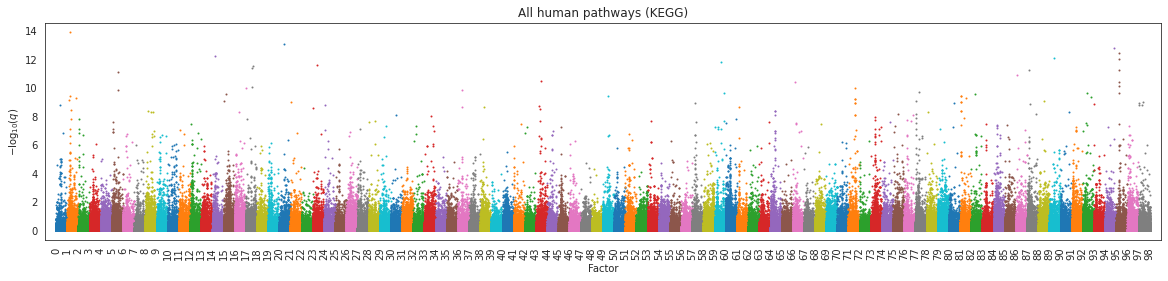

In [ ]:
sns.set_style('white')
plt.figure(figsize=(20, 4))
ax = plt.gca()
cmap = plt.get_cmap('tab10')

n_metagenes = 50
n_factors = 99
for f in range(n_factors):
    df = results_df[results_df['Factor'] == f]
    for x in range(n_metagenes):
        df_meta = df[df['Metagene'] == x]
        y = -np.log10(df_meta['fdr'].values)
        x_pos = [f + (x/n_metagenes)] * len(y)
        ax.scatter(x_pos, y, s=1, color=cmap(f % 10))
plt.xlabel('Factor')
plt.ylabel('$-\log_{10}(q)$')
plt.title('All human pathways (KEGG)')
plt.xticks(list(range(n_factors)))
plt.xticks(rotation = 90)
plt.xlim((-1, 99))
# plt.axhline(y = -np.log10(0.05), color = 'gray', linestyle = '--', linewidth=1)
plt.savefig(f'{RESULTS_DIR}/figures/manhattan_blitzgsea.pdf', bbox_inches='tight');
# plt.savefig('overleaf/figures/manhattan_blitzgsea.png', bbox_inches='tight');

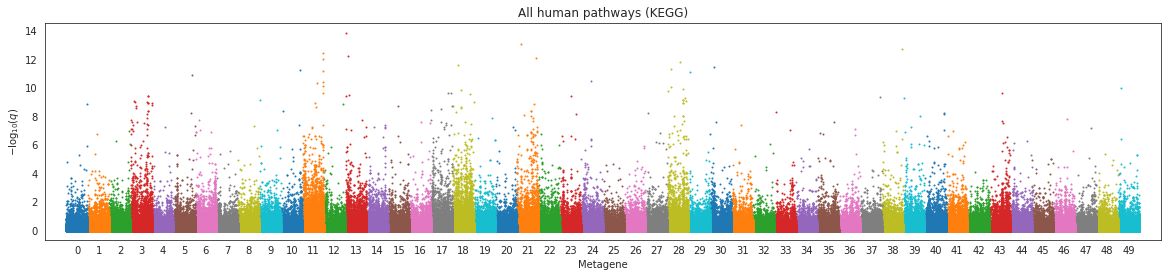

In [ ]:
sns.set_style('white')
plt.figure(figsize=(20, 4))
ax = plt.gca()
cmap = plt.get_cmap('tab10')

n_metagenes = 50
n_factors = 99
for f in range(n_factors):
    df = results_df[results_df['Factor'] == f]
    for x in range(n_metagenes):
        df_meta = df[df['Metagene'] == x]
        y = -np.log10(df_meta['fdr'].values)
        x_pos = [x + (f/n_factors)] * len(y)
        ax.scatter(x_pos, y, s=1, color=cmap(x % 10))
plt.xlabel('Metagene')
plt.ylabel('$-\log_{10}(q)$')
plt.title('All human pathways (KEGG)')
locs = list(range(n_metagenes))
# plt.xticks(locs, rotation = 90)
plt.gca().set_xticklabels('')
plt.gca().set_xticks(np.array(locs) + 0.5, minor=True)
plt.gca().set_xticklabels(locs, minor=True)
plt.xlim((-1, 51))
# plt.axhline(y = -np.log10(0.05), color = 'gray', linestyle = '--', linewidth=1)
# plt.savefig(f'{RESULTS_DIR}/figures/manhattan_metagenes_blitzgsea.pdf', bbox_inches='tight');
plt.savefig(f'{RESULTS_DIR}/figures/manhattan_metagenes_blitzgsea.pdf', bbox_inches='tight');
# plt.savefig('overleaf/figures/manhattan_blitzgsea.png', bbox_inches='tight');

#### Families of pathways

In [ ]:
def list_KEGG_human_pathways():
    lines = REST.kegg_list('pathway', 'hsa').readlines()
    symbols = np.array([s.split('\t')[0].split(':')[-1] for s in lines])
    description = np.array([s.split('\t')[1].rstrip() for s in lines])
    return symbols, description

def get_pathway_class(pathway):
    pathway_file = REST.kegg_get(pathway).read()  # query and read each pathway
    
    pathway_class = None 
    for line in pathway_file.rstrip().split('\n'):
        section = line[:12].strip()  # section names are within 12 columns
        if not section == '':
            current_section = section

        if current_section == 'CLASS':
            if pathway_class is not None:
                print('Pathway belongs to more than one class')
                break
            pathway_class = line[12:]
                
    return pathway_class

In [ ]:
hp, hp_desc = list_KEGG_human_pathways()

In [ ]:
results_df_significant = results_df[results_df['fdr'] < 0.05].copy()
pathway_classes_dict = {}
for term in tqdm(np.unique(results_df_significant.index)):
    pathway_idx = np.where([term.lower() in p.lower() for p in hp_desc])[0]
    if len(pathway_idx) == 0:
        pathway_classes_dict[term] = 'Unknown'
    else:
        pathway_idx = pathway_idx[0]
        pathway_code = hp[pathway_idx]
        pathway_classes_dict[term] = get_pathway_class(pathway_code)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 296/296 [05:55<00:00,  1.20s/it]


In [ ]:
families_dict = {k: p.split(';')[0] for k, p in pathway_classes_dict.items()}
classes_dict = {k: p.split(';')[1].lstrip() if len(p.split(';')) > 1 else p.split(';')[0] for k, p in pathway_classes_dict.items()}

In [ ]:
results_df_significant['class'] = results_df_significant.index.map(classes_dict)
results_df_significant['Category'] = results_df_significant.index.map(families_dict)

In [ ]:
def f(a):
    indexes = np.unique(a, return_index=True)[1]
    return a[np.sort(indexes)]

sorted_idxs = np.argsort(results_df_significant['Category'].values)

f(np.array(results_df_significant['class'].values))

array(['Folding, sorting and degradation', 'Immune system',
       'Transport and catabolism', 'Infectious disease: bacterial',
       'Infectious disease: parasitic', 'Immune disease',
       'Cardiovascular disease', 'Endocrine and metabolic disease',
       'Cellular community - eukaryotes', 'Translation',
       'Carbohydrate metabolism', 'Environmental adaptation',
       'Endocrine system', 'Energy metabolism',
       'Neurodegenerative disease', 'Infectious disease: viral',
       'Lipid metabolism', 'Amino acid metabolism',
       'Cancer: specific types', 'Unknown',
       'Development and regeneration', 'Nervous system',
       'Circulatory system', 'Replication and repair', 'Transcription',
       'Signal transduction', 'Signaling molecules and interaction',
       'Cell motility', 'Digestive system', 'Cancer: overview',
       'Excretory system', 'Glycan biosynthesis and metabolism', 'Aging',
       'Cell growth and death', 'Substance dependence',
       'Metabolism of othe

In [ ]:
sorted_classes = []
for c in np.array(results_df_significant['class'].values)[sorted_idxs]:
    if c not in sorted_classes:
        sorted_classes.append(c)
sorted_classes

['Transport and catabolism',
 'Cell growth and death',
 'Cellular community - eukaryotes',
 'Cell motility',
 'Signaling molecules and interaction',
 'Signal transduction',
 'Membrane transport',
 'Translation',
 'Replication and repair',
 'Folding, sorting and degradation',
 'Transcription',
 'Cancer: specific types',
 'Cancer: overview',
 'Cardiovascular disease',
 'Infectious disease: parasitic',
 'Neurodegenerative disease',
 'Infectious disease: bacterial',
 'Infectious disease: viral',
 'Immune disease',
 'Endocrine and metabolic disease',
 'Substance dependence',
 'Lipid metabolism',
 'Energy metabolism',
 'Glycan biosynthesis and metabolism',
 'Xenobiotics biodegradation and metabolism',
 'Amino acid metabolism',
 'Carbohydrate metabolism',
 'Nucleotide metabolism',
 'Metabolism of other amino acids',
 'Metabolism of cofactors and vitamins',
 'Metabolism of terpenoids and polyketides',
 'Development and regeneration',
 'Digestive system',
 'Immune system',
 'Sensory system',
 '

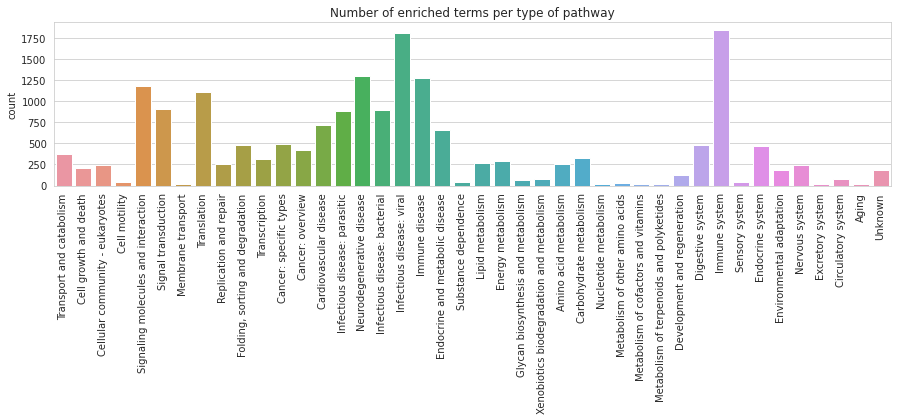

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(15, 3))
sns.countplot(x='class', # hue='Category',
            data=results_df_significant.reset_index(),
            # height=4,
            # aspect=4,
            ax=plt.gca(),
            order=sorted_classes)
# plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -0.9), fancybox=True, shadow=True, ncol=4)
plt.xticks(rotation=90);
plt.xlabel('')
# plt.ylabel('')
plt.title('Number of enriched terms per type of pathway')
# plt.savefig(f'{RESULTS_DIR}/figures/enriched_terms_pathway_type_blitzgsea.pdf', bbox_inches='tight');
plt.savefig('/home/rv340/multitissue_imputation/overleaf/figures/enriched_terms_pathway_type_blitzgsea.pdf', bbox_inches='tight'); 

In [ ]:
results_df_significant[results_df_significant['class'] == 'Neurodegenerative disease']

,es,nes,pval,sidak,fdr,geneset_size,leading_edge,Factor,Metagene,class,Category
Term,,,,,,,,,,,
PARKINSON DISEASE,-0.328745,-3.493032,4.775694e-04,0.139286,0.037489,192,"MCU,COX5B,PSMD3,DAXX,CASP9,NDUFA6,NDUFA9,UBC,C...",0,9,Neurodegenerative disease,Human Diseases
AMYOTROPHIC LATERAL SCLEROSIS,-0.285781,-3.773130,1.612126e-04,0.049365,0.016874,272,"COX7A2L,XBP1,SIGMAR1,NXF1,MAPK13,NDUFA13,PSMD6...",0,14,Neurodegenerative disease,Human Diseases
PARKINSON DISEASE,-0.435069,-5.134704,2.825881e-07,0.000089,0.000030,192,"TUBA1B,PSMC1,NDUFV3,UBA1,XBP1,NDUFA12,KIF5A,ND...",0,18,Neurodegenerative disease,Human Diseases
ALZHEIMER DISEASE,-0.331530,-5.053234,4.343918e-07,0.000136,0.000034,273,"FADD,TUBA1B,PSMC1,BACE1,NDUFV3,MAPK3,XBP1,NDUF...",0,18,Neurodegenerative disease,Human Diseases
HUNTINGTON DISEASE,-0.364913,-4.636326,3.546567e-06,0.001113,0.000153,226,"TGM2,TUBA1B,PSMC1,NDUFV3,TAF4B,DCTN3,NDUFA12,K...",0,18,Neurodegenerative disease,Human Diseases
...,...,...,...,...,...,...,...,...,...,...,...
AMYOTROPHIC LATERAL SCLEROSIS,-0.288168,-3.946484,7.930728e-05,0.024596,0.006226,272,"SRSF3,PSMD6,RAC1,SEC13,MAPK14,NDUFA9,PSMD14,TO...",97,17,Neurodegenerative disease,Human Diseases
PARKINSON DISEASE,-0.359977,-3.745854,1.797811e-04,0.054892,0.014113,192,"SDHD,PSMD6,NDUFC2,PSMD2,NDUFB10,PSMD7,PSMB4,AD...",97,18,Neurodegenerative disease,Human Diseases
ALZHEIMER DISEASE,-0.281911,-3.548813,3.869718e-04,0.114438,0.024302,273,"SDHD,PSMD6,CSNK1A1,NDUFC2,FZD4,PSMD2,NDUFB10,C...",97,18,Neurodegenerative disease,Human Diseases


#### FDR neurodegenerative

In [ ]:
cutoff = 0.05
aggregated_df = pd.DataFrame()
for m in range(50):
    df = results_df[results_df['Metagene'] == m].reset_index()[['Term', 'fdr', 'Factor']].set_index(['Term', 'Factor']).unstack()
    aggregated_df[m] = df.min(axis=1)

In [ ]:
neurodegenerative_pathways = ['PATHWAYS OF NEURODEGENERATION',
                              'AMYOTROPHIC LATERAL SCLEROSIS', 
                              'ALZHEIMER DISEASE',
                              'PARKINSON DISEASE',
                              'HUNTINGTON DISEASE',
                              'PRION DISEASE',
                              'SPINOCEREBELLAR ATAXIA']

min_fdr_per_term = aggregated_df.min(axis=1)
mean_fdr_per_term = aggregated_df.mean(axis=1)
df = aggregated_df[min_fdr_per_term < 0.05]
mask = [s in neurodegenerative_pathways for s in df.index]  
df = df[mask]
fdr_mask = df.values < 0.05
df = -np.log10(df + 1e-10)

In [ ]:
sum([s in neurodegenerative_pathways for s in results_df[results_df['fdr'] < 0.05].index])

2109

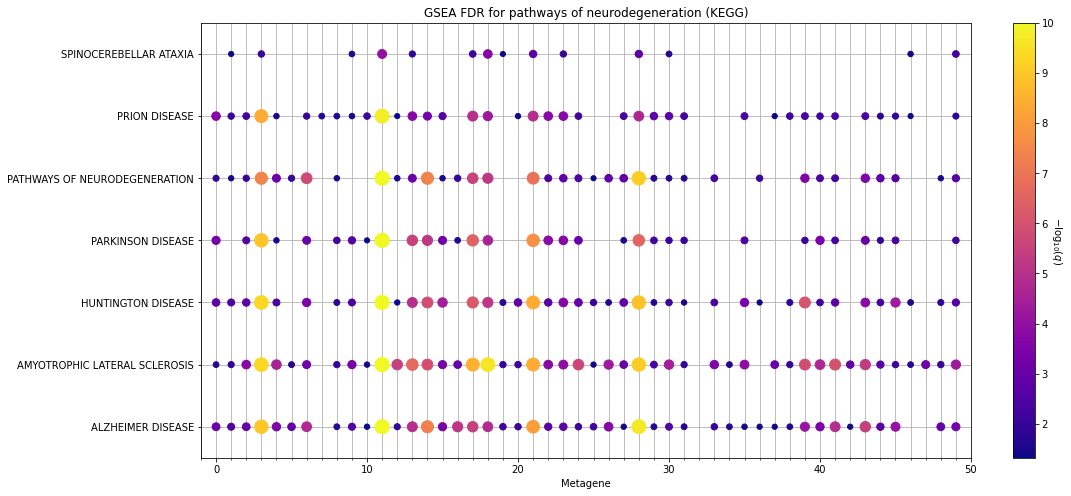

In [ ]:
sns.reset_orig()
x = np.arange(50)
y = np.arange(df.shape[0])
x_, y_ = np.meshgrid(x, y)
sizes = 20*df.values  # 0.01/(df.values+1e-5)

sizes = sizes[fdr_mask]
x_ = x_[fdr_mask]
y_ = y_[fdr_mask]
c = df.values[fdr_mask]

plt.figure(figsize=(15, 8))
cmap = plt.cm.plasma
norm = matplotlib.colors.Normalize()
plt.scatter(x_.flatten(), y_.flatten(), s=sizes, c=c, norm=norm, cmap=cmap)
plt.yticks(ticks=y, labels=df.index.values)
cbar = plt.colorbar(fraction=0.03)
cbar.set_label('$-\log_{10}(q)$', rotation=270, labelpad=10)

minorLocator = MultipleLocator(base=1.0)
plt.gca().xaxis.set_minor_locator(minorLocator)
plt.gca().grid(which='both')
plt.gca().set_axisbelow(True)
plt.xlim(-1, 50)
plt.ylim(-0.5, 6.5)

plt.xlabel('Metagene')
plt.title('GSEA FDR for pathways of neurodegeneration (KEGG)')
plt.savefig(f'{RESULTS_DIR}/figures/fdr_scatter_metagenes_neurodegeneration_blitzgsea.png', bbox_inches='tight');

#### FDR signaling

In [ ]:
cutoff = 0.05
aggregated_df = pd.DataFrame()
for f in range(99):
    df = results_df[results_df['Factor'] == f].reset_index()[['Term', 'fdr', 'Metagene']].set_index(['Term', 'Metagene']).unstack()
    aggregated_df[f] = df.min(axis=1)

In [ ]:
signaling_pathways = [c for c, f in classes_dict.items() if f == 'Signaling molecules and interaction' or f == 'Signal transduction' or f == 'Membrane transport']

min_fdr_per_term = aggregated_df.min(axis=1)
mean_fdr_per_term = aggregated_df.mean(axis=1)
df = aggregated_df[min_fdr_per_term < 0.05]
mask = [s in signaling_pathways for s in df.index]  
df = df[mask]
fdr_mask = df.values < 0.05
df = -np.log10(df + 1e-10)

In [ ]:
sum([s in signaling_pathways for s in results_df[results_df['fdr'] < 0.05].index])

2109

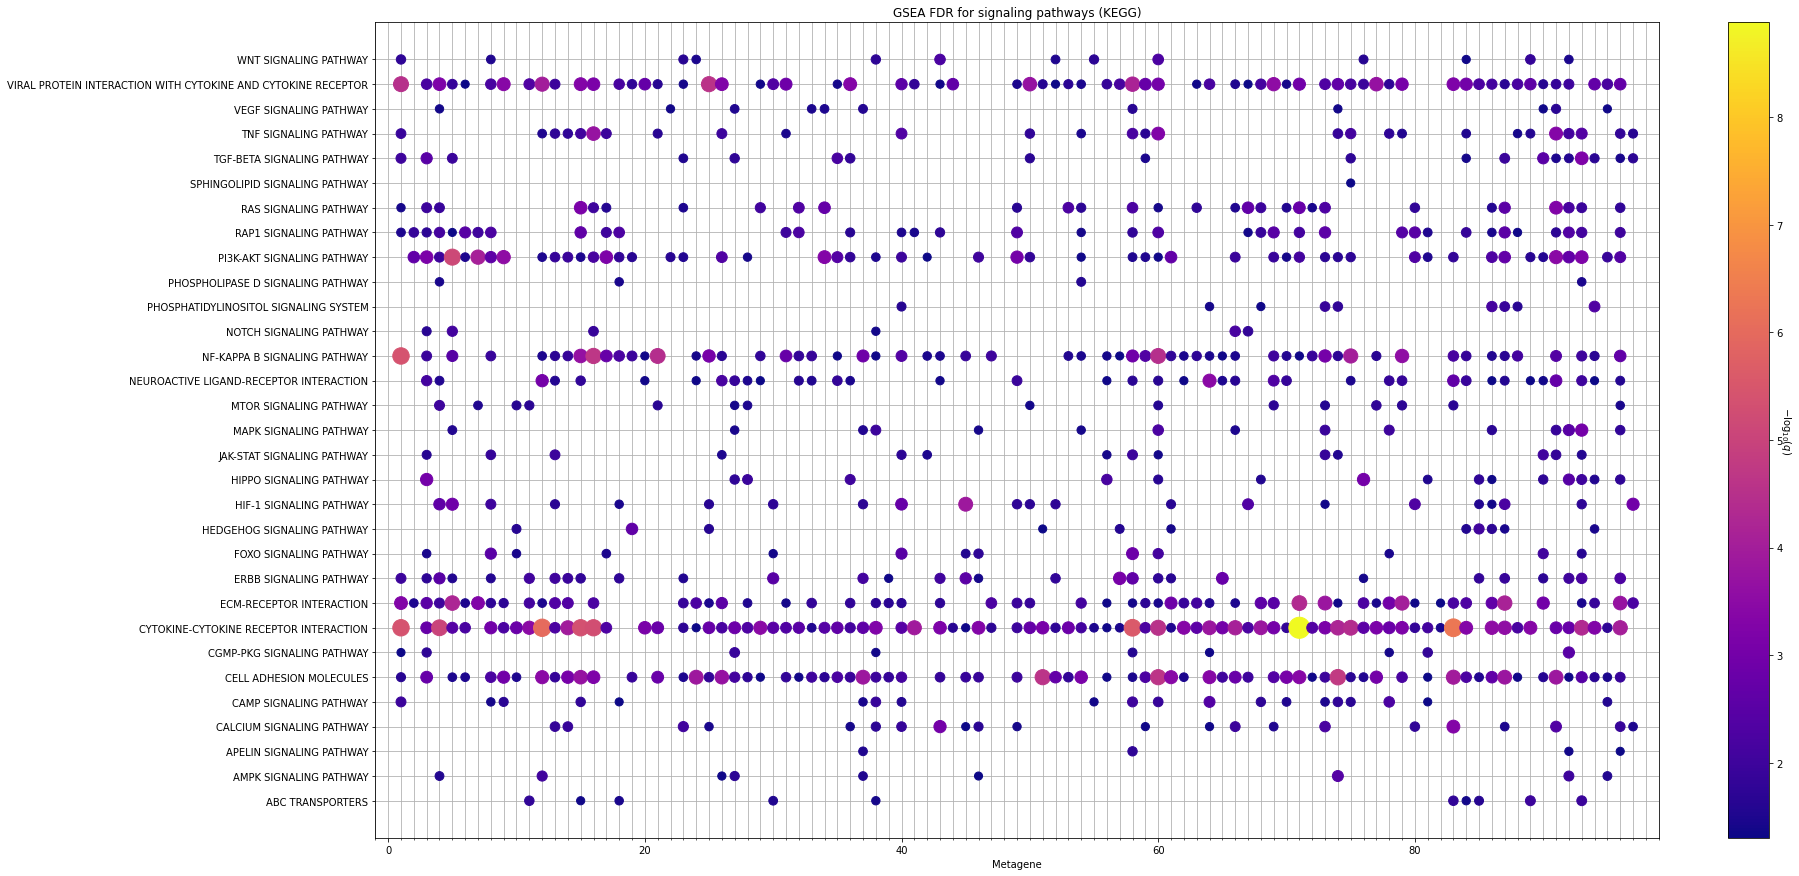

In [ ]:
sns.reset_orig()
x = np.arange(99)
y = np.arange(df.shape[0])
x_, y_ = np.meshgrid(x, y)
sizes = 50*df.values  # 0.01/(df.values+1e-5)

sizes = sizes[fdr_mask]
x_ = x_[fdr_mask]
y_ = y_[fdr_mask]
c = df.values[fdr_mask]

plt.figure(figsize=(25, 15))
cmap = plt.cm.plasma
norm = matplotlib.colors.Normalize()
plt.scatter(x_.flatten(), y_.flatten(), s=sizes, c=c, norm=norm, cmap=cmap)
plt.yticks(ticks=y, labels=df.index.values)
cbar = plt.colorbar(fraction=0.03)
cbar.set_label('$-\log_{10}(q)$', rotation=270, labelpad=10)

minorLocator = MultipleLocator(base=1.0)
plt.gca().xaxis.set_minor_locator(minorLocator)
plt.gca().grid(which='both')
plt.gca().set_axisbelow(True)
plt.xlim(-1, 99)
# plt.ylim(-0.5, 6.5)

plt.xlabel('Metagene')
plt.title('GSEA FDR for signaling pathways (KEGG)')
plt.savefig(f'{RESULTS_DIR}/figures/fdr_scatter_factors_signaling_blitzgsea.png', bbox_inches='tight');

#### Neurodegenerative

In [ ]:
subject_df = pd.read_csv(METADATA_FILE, delimiter='\t')
subject_df = subject_df.set_index('SUBJID')

In [ ]:
significant_results_df.loc['ALZHEIMER DISEASE'].sort_values('fdr')

,es,nes,pval,sidak,fdr,geneset_size,leading_edge,Factor,Metagene
Term,,,,,,,,,
ALZHEIMER DISEASE,-0.467554,-inf,0.000000e+00,0.000000e+00,0.000000e+00,273,"CSNK2B,PSMA3,FZD4,UQCRC2,CDK5,NDUFS8,AMBRA1,GA...",95,11
ALZHEIMER DISEASE,-0.405087,-7.270655,3.577478e-13,1.123328e-10,1.123328e-10,273,"NDUFC1,NDUFB7,RELA,PSMA4,FZD2,COX7C,INSR,COX4I...",71,28
ALZHEIMER DISEASE,-0.388549,-6.981264,2.925358e-12,9.185624e-10,9.185624e-10,273,"UQCRQ,NDUFAB1,PIK3R1,CSNK1E,LPL,COX4I1,KIF5A,P...",77,3
ALZHEIMER DISEASE,-0.384805,-6.776495,1.231260e-11,3.866156e-09,1.068596e-09,273,"NDUFB10,NDUFS3,RTN4,PSMA1,NDUFA12,PSMB6,COX6B1...",81,3
ALZHEIMER DISEASE,-0.431542,-6.497623,8.159890e-11,2.562206e-08,8.540685e-09,273,"NDUFB9,PSMD8,PPIF,NDUFV2,NDUFS5,SLC25A6,PSMA2,...",64,21
...,...,...,...,...,...,...,...,...,...
ALZHEIMER DISEASE,0.278482,3.012360,2.592252e-03,5.573713e-01,4.522040e-02,273,"IRS2,FAS,CALM3,FZD9,PSMB6,APH1B,TUBB2B,FZD3,PS...",51,11
ALZHEIMER DISEASE,0.291638,3.511010,4.464068e-04,1.308183e-01,4.526620e-02,273,"AKT3,MAP2K2,GRIN2D,TNFRSF1A,NDUFA6,IRS1,CASP7,...",75,14
ALZHEIMER DISEASE,-0.278587,-3.377079,7.326007e-04,2.055625e-01,4.600732e-02,273,"WIPI2,MAPK8,APAF1,UQCR10,PSEN2,PPID,TUBA1B,NDU...",87,39


In [ ]:
aux_val_dataset_ = HypergraphDataset(adata,
                                  obs_source={'Tissue': ['Brain_Cortex']})
aux_val_loader_ = DataLoader(aux_val_dataset_, batch_size=len(aux_val_dataset_),
                             collate_fn=collate_fn, shuffle=False)

# Compute predictions and score
model.eval()
with torch.no_grad():
    d = next(iter(aux_val_loader_))
    d = d.to(device)
    x_source = d.x_source
    x_source = model.encode_metagenes(x_source)

x_source = x_source.detach().cpu()
participant_idxs = d.source['Participant ID'].detach().cpu().numpy()
participant_idxs = [aux_val_dataset_.donor_map[p] for p in participant_idxs]

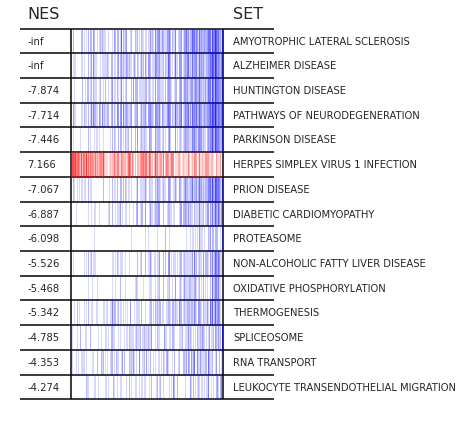

In [ ]:
factor_id = 95
metagene_idx = 11
gene_idxs = np.argsort(metagene_w[metagene_idx, factor_id, :])[::-1]
gene_names = adata.var['Symbol'][gene_idxs].values
gene_values = metagene_w[metagene_idx, factor_id, gene_idxs]
signature = pd.DataFrame({0: gene_names, 1: gene_values})
# result = blitz.gsea(signature, library, permutations=100)

df = results_df[(results_df['Factor'] == factor_id) & (results_df['Metagene'] == metagene_idx)]
fig = blitz.plot.top_table(signature, library, df, n=15)

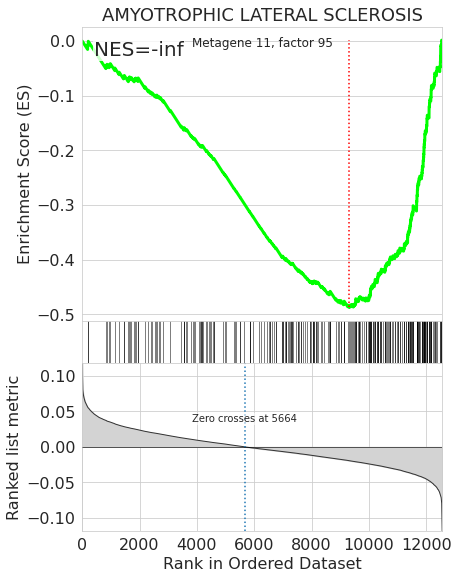

In [ ]:
fig = blitz.plot.running_sum(signature, df.index[0], library, result=df, compact=False)
plt.suptitle(f'Metagene {metagene_idx}, factor {factor_id}')
fig.set_size_inches((5, 7))

(Counter({0: 198, 1: 6, 99: 1}), Counter({0: 929, 1: 17, 99: 2}))

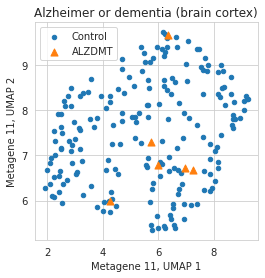

In [ ]:
key = 'MHALZDMT'
x = x_source[:, 11, :]

x_2d = umap.UMAP(random_state=0).fit_transform(x)

plt.figure(figsize=(4, 4))
y = subject_df.loc[participant_idxs][key]
plt.scatter(x_2d[y==0, 0], x_2d[y==0, 1], s=20, cmap=matplotlib.cm.summer, label='Control')
plt.gca().scatter(x_2d[y==1, 0], x_2d[y==1, 1], s=50, marker='^', cmap=matplotlib.cm.summer, label='ALZDMT')
plt.legend(loc='upper left')
plt.title('Alzheimer or dementia (brain cortex)')
plt.xlabel('Metagene 11, UMAP 1')
plt.ylabel('Metagene 11, UMAP 2')
plt.savefig(f'{RESULTS_DIR}/figures/metagenes_ALZDMT_cortex.pdf', bbox_inches='tight');
Counter(y), Counter(subject_df[key])

In [ ]:
significant_results_df.loc['AMYOTROPHIC LATERAL SCLEROSIS'].sort_values('fdr')

,es,nes,pval,sidak,fdr,geneset_size,leading_edge,Factor,Metagene
Term,,,,,,,,,
AMYOTROPHIC LATERAL SCLEROSIS,-0.487191,-inf,0.000000e+00,0.000000e+00,0.000000e+00,272,"GPX2,PSMA3,UQCRC2,NDUFS8,AMBRA1,PSMB5,NDUFB7,P...",95,11
AMYOTROPHIC LATERAL SCLEROSIS,-0.396399,-7.241107,4.450358e-13,1.397412e-10,1.397412e-10,272,"SIGMAR1,VCP,PSMD2,ALYREF,CASP3,NUP107,PSMC4,TP...",36,18
AMYOTROPHIC LATERAL SCLEROSIS,-0.393781,-7.016989,2.267010e-12,7.118412e-10,3.559206e-10,272,"ACTR1A,CAT,NDUFB10,NDUFS3,PSMA1,NDUFA12,PSMB6,...",81,3
AMYOTROPHIC LATERAL SCLEROSIS,-0.390171,-6.879322,6.013819e-12,1.888339e-09,6.572102e-10,272,"NDUFC1,NDUFB7,CHCHD10,PSMA4,COX7C,COX4I1,UQCR1...",71,28
AMYOTROPHIC LATERAL SCLEROSIS,-0.403806,-6.949674,3.661317e-12,1.149654e-09,1.149654e-09,272,"SDHA,NDUFV3,PSMB7,PSMC4,COX6A1,TPR,PSMC6,BECN1...",57,11
...,...,...,...,...,...,...,...,...,...
AMYOTROPHIC LATERAL SCLEROSIS,-0.286146,-3.787600,1.521092e-04,4.664308e-02,4.776229e-02,272,"NDUFB3,CCS,NUP62,BAX,KIF5A,HNRNPA2B1,DCTN2,NDU...",95,3
AMYOTROPHIC LATERAL SCLEROSIS,0.284826,3.781686,1.557695e-04,4.773836e-02,4.891164e-02,272,"POM121,DAXX,MAPK11,GLE1,DCTN6,HNRNPA1,ACTR10,N...",44,19
AMYOTROPHIC LATERAL SCLEROSIS,-0.271711,-3.226856,1.251586e-03,3.251360e-01,4.912474e-02,272,"PSMD2,FUS,NDUFA10,MAPK12,CHMP2B,WIPI1,UQCRC2,N...",67,6


In [ ]:
# Hypergraph baseline (all tissues)
# Select same set of individuals
aux_val_dataset_ = HypergraphDataset(adata,
                                  obs_source={'Tissue': ['Brain_Spinal_cord']})
aux_val_loader_ = DataLoader(aux_val_dataset_, batch_size=len(aux_val_dataset_),
                             collate_fn=collate_fn, shuffle=False)

# Compute predictions and score
model.eval()
with torch.no_grad():
    d = next(iter(aux_val_loader_))
    d = d.to(device)
    x_source = d.x_source
    x_source = model.encode_metagenes(x_source)

x_source = x_source.detach().cpu()
participant_idxs = d.source['Participant ID'].detach().cpu().numpy()
participant_idxs = [aux_val_dataset_.donor_map[p] for p in participant_idxs]

(Counter({0: 124, 1: 2}), Counter({0: 937, 99: 7, 1: 4}))

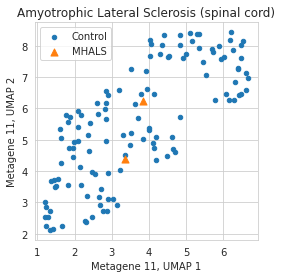

In [ ]:
sns.set_style('whitegrid')
key = 'MHALS' # 'MHALS'
x = x_source[:, 11, :]

x_2d = umap.UMAP(random_state=0).fit_transform(x)

plt.figure(figsize=(4, 4))
y = subject_df.loc[participant_idxs][key]
plt.scatter(x_2d[y==0, 0], x_2d[y==0, 1], s=20, cmap=matplotlib.cm.summer, label='Control')
plt.gca().scatter(x_2d[y==1, 0], x_2d[y==1, 1], s=50, marker='^', cmap=matplotlib.cm.summer, label=key)
plt.legend(loc='upper left')
plt.title('Amyotrophic Lateral Sclerosis (spinal cord)')
plt.xlabel('Metagene 11, UMAP 1')
plt.ylabel('Metagene 11, UMAP 2')
plt.savefig(f'{RESULTS_DIR}/figures/metagenes_MHALS_spinalcord.pdf', bbox_inches='tight');
Counter(y), Counter(subject_df[key])

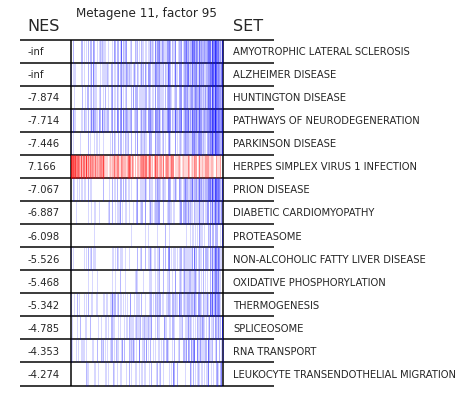

In [ ]:
factor_id = 95
metagene_idx = 11
gene_idxs = np.argsort(metagene_w[metagene_idx, factor_id, :])[::-1]
gene_names = adata.var['Symbol'][gene_idxs].values
gene_values = metagene_w[metagene_idx, factor_id, gene_idxs]
signature = pd.DataFrame({0: gene_names, 1: gene_values})
# result = blitz.gsea(signature, library, permutations=100)

df = results_df[(results_df['Factor'] == factor_id) & (results_df['Metagene'] == metagene_idx)]
fig = blitz.plot.top_table(signature, library, df, n=15)
plt.title(f'Metagene {metagene_idx}, factor {factor_id}')
fig.set_size_inches((5, 7))
plt.savefig(f'{RESULTS_DIR}/figures/metagenes_ALS_ALZDMT_top_plot.pdf', bbox_inches='tight')

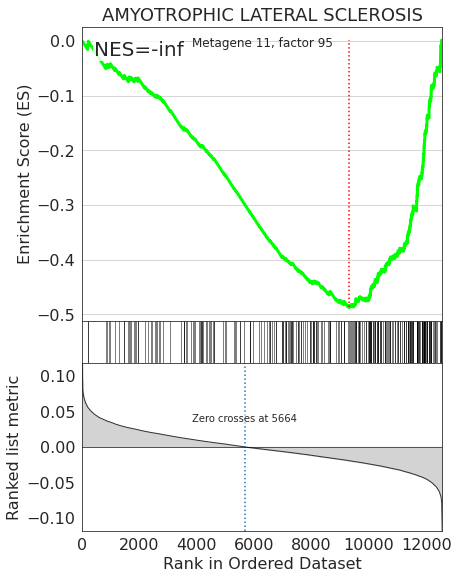

In [ ]:
fig = blitz.plot.running_sum(signature, df.index[0], library, result=df, compact=False)
plt.suptitle(f'Metagene {metagene_idx}, factor {factor_id}')
fig.set_size_inches((5, 7))
plt.savefig(f'{RESULTS_DIR}/figures/metagenes_ALS_running_sum.pdf', bbox_inches='tight')

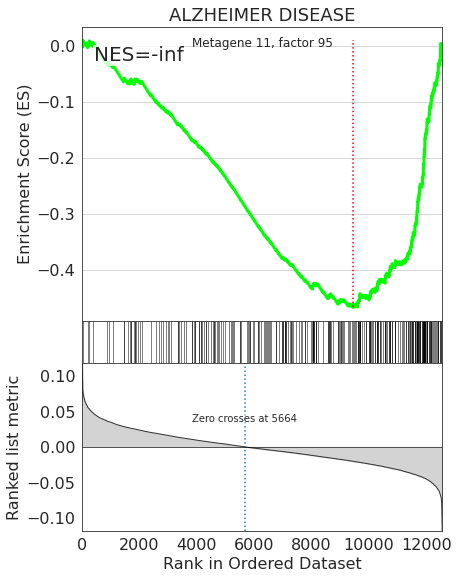

In [ ]:
fig = blitz.plot.running_sum(signature, df.index[1], library, result=df, compact=False)
plt.suptitle(f'Metagene {metagene_idx}, factor {factor_id}')
fig.set_size_inches((5, 7))
plt.savefig(f'{RESULTS_DIR}/figures/metagenes_Alzheimer_running_sum.pdf', bbox_inches='tight')

#### Store predictions

In [ ]:
def create_dataframe(participant_ids, tissue_ids, expression, donor_map, tissue_dict_inv, symbols):
    participant_ids = np.concatenate(participant_ids, axis=0)
    tissue_ids = np.concatenate(tissue_ids, axis=0)
    expression = np.concatenate(expression, axis=0)
    df_metadata = pd.DataFrame({'Participant ID': [donor_map[p] for p in participant_ids],
                               'Tissue': [tissue_dict_inv[t] for t in tissue_ids]})
    df = pd.DataFrame(expression, columns=symbols)
    df = pd.concat([df_metadata, df], axis=1)
    df = df.set_index('Participant ID')
    return df

In [ ]:
dataset = HypergraphDataset(adata, static=True)
loader = DataLoader(dataset, batch_size=config.batch_size, collate_fn=collate_fn, shuffle=False)

In [ ]:
model.eval()
# df_imputed = pd.DataFrame({'Participant ID': [], 'Tissue ID': [], })
source_participant_ids = []
source_tissue_ids = []
source_expression = []
target_participant_ids = []
target_tissue_ids = []
target_expression = []
for i, d in tqdm(enumerate(dataset)):
    # Set target tissues to missing tissues
    d.target['Tissue'] = torch.tensor([t for t in np.arange(len(tissue_dict)) if t not in d.source['Tissue']])
    d.target['Participant ID'] = torch.zeros_like(d.target['Tissue']) + d.source['Participant ID'][0]
    d.x_target = torch.tensor([-1])  # Unused
    
    # Make predictions
    with torch.no_grad():
        out, node_features = forward(d, model, device, preprocess_fn=None) 
        y_pred = out['px_rate']
    
    # Store
    source_participant_ids.append(d.source['Participant ID'].cpu().numpy() + i)
    source_tissue_ids.append(d.source['Tissue'].cpu().numpy())
    source_expression.append(d.x_source.cpu().numpy())
    target_participant_ids.append(d.target['Participant ID'].cpu().numpy() + i)
    target_tissue_ids.append(d.target['Tissue'].cpu().numpy())
    target_expression.append(y_pred.cpu().numpy())

# Store data in dataframes
df_imputed = create_dataframe(target_participant_ids, target_tissue_ids, target_expression,
                              donor_map=dataset.donor_map,
                              tissue_dict_inv=tissue_dict_inv,
                              symbols=adata.var['Symbol'])
df_observed = create_dataframe(source_participant_ids, source_tissue_ids, source_expression,
                               donor_map=dataset.donor_map,
                               tissue_dict_inv=tissue_dict_inv,
                               symbols=adata.var['Symbol'])

834it [00:17, 47.67it/s]


In [ ]:
df_imputed[df_imputed['Tissue'] == 'Artery_Aorta']

,Tissue,A1BG,A2LD1,A2M,A2ML1,A4GALT,AAAS,AACS,AAED1,AAGAB,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
Participant ID,,,,,,,,,,,,,,,,,,,,,
GTEX-1117F,Artery_Aorta,0.257082,0.378651,0.154134,0.316211,-0.013119,-0.010759,-0.197401,-0.494546,-0.265066,...,-0.172205,0.047460,-0.341376,0.126275,-0.505605,-0.274176,-0.255620,-0.842843,-0.568091,0.055943
GTEX-111CU,Artery_Aorta,0.002665,0.389942,0.346620,-0.052226,0.564628,-0.656273,0.302192,0.874769,0.648722,...,0.096149,0.543271,0.612956,-0.075804,0.318072,0.394054,0.199846,0.611881,0.499142,-0.358676
GTEX-111FC,Artery_Aorta,0.293621,0.249431,-0.517879,0.438297,-0.154100,0.625865,-0.144976,-0.306126,-0.998666,...,-0.230577,-0.057246,-0.078341,0.564028,-0.253982,-0.413667,-0.010309,-0.254609,-1.040523,0.267135
GTEX-111VG,Artery_Aorta,0.771344,-0.236216,-0.535619,0.188505,-0.140259,1.120982,-0.658741,-1.009128,-1.489605,...,-1.932925,-0.802582,-0.133305,-0.691714,-1.113214,-1.744444,-1.402675,0.072222,-0.752181,-0.871815
GTEX-113IC,Artery_Aorta,-0.590425,1.083275,-0.096241,0.315791,-0.623890,-0.410357,-0.093608,-0.167157,-0.324222,...,0.377928,0.588034,0.765436,0.868805,0.421963,-0.282495,0.305492,-0.809442,-0.697004,0.471788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTEX-ZY6K,Artery_Aorta,-0.507383,0.297367,-0.139823,0.072850,0.262647,-1.270423,0.519790,0.307852,0.892991,...,0.601988,0.437369,0.653892,-0.284718,-0.222694,0.160664,0.190231,-0.240224,0.325617,0.188111
GTEX-ZYFC,Artery_Aorta,0.109893,0.291655,-0.768099,0.458483,-0.191078,0.393394,-0.714552,-1.062461,-1.405635,...,-1.213121,-0.085925,-0.083268,0.337888,-0.394950,-1.014847,-0.303551,-0.175145,-0.599895,0.290908
GTEX-ZYVF,Artery_Aorta,0.184439,0.041576,-0.055782,0.281868,0.727235,0.606937,0.518981,-0.984885,0.495537,...,0.297752,-1.063018,-0.810890,-0.400333,-0.768935,-0.975668,-0.340527,-0.828252,-0.963353,0.591209


In [ ]:
df_observed.to_csv(f'{RESULTS_DIR}/observed_normalised.csv')
df_imputed.to_csv(f'{RESULTS_DIR}/imputed_normalised.csv')